## Residual layers worked well on a single model

Lb at `0.01856`

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv


In [2]:
!rm train_targets_folds.csv
!wget https://github.com/Mayukhdeb/moa-classification-with-model-blending/raw/main/folds/train_targets_folds.csv

rm: cannot remove 'train_targets_folds.csv': No such file or directory
--2020-10-14 12:25:36--  https://github.com/Mayukhdeb/moa-classification-with-model-blending/raw/main/folds/train_targets_folds.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Mayukhdeb/moa-classification-with-model-blending/main/folds/train_targets_folds.csv [following]
--2020-10-14 12:25:37--  https://raw.githubusercontent.com/Mayukhdeb/moa-classification-with-model-blending/main/folds/train_targets_folds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10182351 (9.7M) [text/plain]
Saving to: ‘train_targets_folds.csv’

train_targets_folds 100%[===========

In [3]:
!pip install iterative-stratification

In [4]:
!pip install optuna

In [5]:
pd.read_csv("./train_targets_folds.csv").head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_95029ba69,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,id_937bf8e8f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,id_59e0b53af,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,id_1b0b65599,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,id_1d650ed9d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

import numpy as np 
import pandas as pd 

from IPython.display import clear_output
import random 
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm, tnrange
import os

plt.rcParams['figure.figsize'] = 15, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=1903):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print("seed kar diya")

In [7]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device


'cuda'

In [8]:

def preprocess(df, select_features):
    df = df.copy()
    top_features = [ 0, 1, 2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]
    all_columns = df.columns

    if select_features == True:
        df=df[all_columns[top_features]]
    else:
        pass
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({ 24: 0, 48: 0.5, 72: 1})
    
    return df

In [9]:
class MoaDataset(Dataset):
    def __init__(self,features,targets):
        
        self.features  = features
        self.targets = targets
       
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])
        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, item):
        return {
            "x": torch.tensor(self.features[item, :], dtype=torch.float),
            "y": torch.tensor(self.targets[item, :], dtype=torch.float)
        }

In [10]:

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.0008):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        bcs_loss = nn.BCEWithLogitsLoss()(x, target)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * bcs_loss + smoothing * smooth_loss
        return loss.mean()
    
    
class Engine:
      def __init__(self, model, optimizer, device, scheduler):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        
       
      @staticmethod
      def loss_fn_backprop(targets, outputs):
        return LabelSmoothingCrossEntropy()(outputs, targets)
    
      @staticmethod
      def loss_fn_stop(targets, outputs):
        return nn.BCEWithLogitsLoss()(outputs, targets)

      def train(self, data_loader):
        self.model.train()
        final_loss=0
        for data in data_loader:
            self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn_backprop(targets, outputs)
            loss_stop = self.loss_fn_stop(targets, outputs)
            loss.backward()
            
            self.optimizer.step()
            
            final_loss += loss_stop.item()
        self.scheduler.step(1.)
        return(final_loss / len(data_loader))


      def evaluate(self, data_loader):
        self.model.eval()
        final_loss=0
        for data in data_loader:
            #self.optimizer.zero_grad()
            inputs = data["x"].to(self.device)
            targets = data["y"].to(self.device)
            outputs = self.model(inputs)
            loss = self.loss_fn_stop(targets, outputs)
            #loss.backward()
            #self.optimizer.step()
            final_loss += loss.item()
        return(final_loss / len(data_loader))

In [11]:
df_main = pd.read_csv('../input/lish-moa/train_features.csv')

    

def run_training(model_class ,fold, save_model=True, select_features = False, model_id = 0, lr = 0.004299882049752947, decay_factor = 0.1, patience = 7, df = df_main, num_epochs = 100):
    
    df = preprocess(df, select_features = select_features)
    targets_df = pd.read_csv('./train_targets_folds.csv')

    feature_columns = df.drop("sig_id", axis=1).columns
    target_columns = targets_df.drop(["sig_id", "kfold"], axis=1).columns

    

    df = df.merge(targets_df, on="sig_id", how="left")
    df = df[df.kfold != "hold"]

    train_df = df[df.kfold != str(fold)].reset_index(drop=True)
    valid_df = df[df.kfold == str(fold)].reset_index(drop=True)

    
    x_train = train_df[feature_columns].to_numpy()
    y_train = train_df[target_columns].to_numpy()
    
    x_val = valid_df[feature_columns].to_numpy()
    y_val = valid_df[target_columns].to_numpy()
    
    train_dataset = MoaDataset(features = x_train, targets=y_train)
    valid_dataset = MoaDataset(features = x_val, targets=y_val)
    
    train_loader = DataLoader(
        train_dataset, batch_size=128, shuffle=True
    )
    
    val_loader = DataLoader(
        valid_dataset, batch_size=1024, shuffle=True
    )
    
    model = model_class()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), 
                                       lr = lr, 
                                       weight_decay=1e-5)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=decay_factor, ## wooo hoo
                                                 patience= patience, ## was 3 for 158 
                                                 eps=1e-4, 
                                                 verbose=True)
    criterion = nn.BCEWithLogitsLoss()
    eng = Engine(model, optimizer, 'cuda',scheduler)
    
    best_loss = 999
    early_stop_iter = 15
    early_stop_count=0

    for epoch in range(num_epochs):
        train_loss = eng.train(train_loader)
        valid_loss = eng.evaluate(val_loader)
        #print("train_loss:", train_loss, "val_loss:", valid_loss)
        if valid_loss<best_loss:
            best_loss = valid_loss
            if save_model:
                torch.save(model.state_dict(), "model_"+str(fold + model_id) +".pth")
                pass
        else:
            early_stop_count +=1
            
        if early_stop_count>early_stop_iter:
            break
                    
    return(best_loss)


In [97]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 880))
        
        self.batch_norm2 = nn.BatchNorm1d(880)
        self.dense2 = nn.utils.weight_norm(nn.Linear(880, 880))
    
#         self.batch_norm3 = nn.BatchNorm1d(880)
#         self.dense3 = nn.utils.weight_norm(nn.Linear(880, 880))
        
        
        self.batch_norm_out = nn.BatchNorm1d(880)
        self.dense_out = nn.utils.weight_norm(nn.Linear(880, 206))
    
    def forward(self, x):
        
        x_1 = self.batch_norm1(x)
        x_1_res = self.dense1(x_1)
        x_1 = F.leaky_relu(x_1_res)
        
        x_2 = self.batch_norm2(x_1)
        x_2_res = self.dense2(x_2)
        x_2 = F.leaky_relu(x_2_res + x_1_res) 
    
        x_3 = self.batch_norm2(x_2)
        x_3_res = self.dense2(x_3)
        x_3 = F.leaky_relu(x_3_res + x_2_res + x_1_res) 
        
        x_out = self.batch_norm_out(x_3)
        x_out = self.dense_out(x_out)
        return x_out

In [14]:
# def objective(trial):
#     params = {
#         "lr": trial.suggest_uniform("lr", 1e-3 , 5e-3 ),
# #         "decay_factor" : trial.suggest_uniform("decay_factor", 0.0, 0.5),
#     }
    
#     losses = np.zeros(1)
#     for fold in range(1):
#         loss = run_training(
#             model_class = Model,
#             fold = fold,
#             save_model = False,
#             select_features = True,
#             lr = params["lr"],
#             decay_factor = 0.1,
#             patience  = 7,
#             num_epochs = 2
#         )
#         losses[fold] = loss
        
#     final_loss = losses.mean()
#     return final_loss

In [15]:
# import optuna

In [16]:
# study = optuna.create_study(direction="minimize")

In [17]:

# study.optimize(objective, n_trials=100)

In [18]:
# study.best_params

In [22]:
best_losses = []
num_folds = 7
for fold in range(0, num_folds):
    print(best_losses)
    loss = run_training(
        model_class = Model,
        fold = fold,
        save_model = True,
        select_features = True,
        lr = 4e-3,
        decay_factor = 0.1,
        patience  = 7,
        num_epochs = 100
    )
    best_losses.append(loss)

[]
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
[0.015221434334913889]
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
[0.015221434334913889, 0.015373132812480131]
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
[0.015221434334913889, 0.015373132812480131, 0.015324122893313566]
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
[0.015221434334913889, 0.015373132812480131, 0.015324122893313566, 0.015106334040562311]
Epoch     9: reducing learning rate of group 0 to 4.0000e-04.
Epoch    17: reducing learning rate of group 0 to 4.0000e-05.
[0.015221434334913889, 0.015373132812480131, 0.015324122893313566, 0.015106334040562311, 0.015217458518842856]
Epoch     9: reducing learning rate of gro

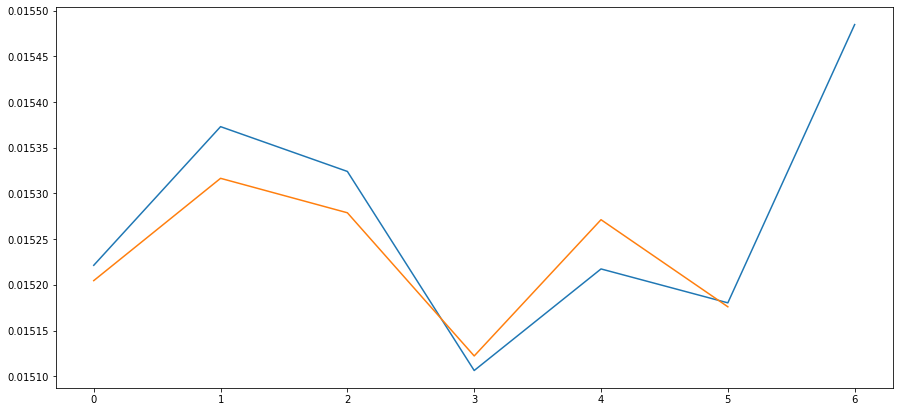

In [23]:
plt.plot(best_losses)
plt.plot([0.015204671770334244, 0.015316605878372988, 0.015278907492756844, 0.015122259967029095, 0.015271329941848913, 0.015176061540842056])

In [ ]:
## best tillnow = [0.015204671770334244, 0.015316605878372988, 0.015278907492756844, 0.015122259967029095, 0.015271329941848913, 0.015176061540842056]


In [87]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        
        
        self.batch_norm1 = nn.BatchNorm1d(875)
        self.dense1 = nn.utils.weight_norm(nn.Linear(875, 880))
        
        self.batch_norm2 = nn.BatchNorm1d(880)
        self.dense2 = nn.utils.weight_norm(nn.Linear(880, 880))
    
#         self.batch_norm3 = nn.BatchNorm1d(880)
#         self.dense3 = nn.utils.weight_norm(nn.Linear(880, 880))
        
        
        self.batch_norm_out = nn.BatchNorm1d(880)
        self.dense_out = nn.utils.weight_norm(nn.Linear(880, 206))
    
    def forward(self, x):
        
        x_1 = self.batch_norm1(x)
        x_1_res = self.dense1(x_1)
        x_1 = F.leaky_relu(x_1_res)
        
        x_2 = self.batch_norm2(x_1)
        x_2_res = self.dense2(x_2)
        x_2 = F.leaky_relu(x_2_res + x_1_res) 
    
        x_3 = self.batch_norm2(x_2)
        x_3_res = self.dense2(x_3)
        x_3 = F.leaky_relu(x_3_res + x_2_res + x_1_res) 
        
        x_out = self.batch_norm_out(x_3)
        x_out = self.dense_out(x_out)
        return x_out

In [88]:
# def objective_2(trial):
#     params = {
#         "lr": trial.suggest_uniform("lr", 0.5e-4 , 5e-3 ),
#         "decay_factor" : trial.suggest_uniform("decay_factor", 0.01,  0.9),
#     }
    
#     losses = np.zeros(1)
#     for fold in range(1):
#         loss = run_training(
#             model_class = Model_2,
#             fold = fold,
#             save_model = False,
#             select_features = False,
#             lr = params["lr"],
#             decay_factor = params["decay_factor"],
#             patience  = 7,
#             num_epochs = 2,
#             model_id = 100
#         )
#         losses[fold] = loss
        
#     final_loss = losses.mean()
#     return final_loss

In [89]:
# study = optuna.create_study(direction="minimize")


In [90]:
# study.optimize(objective_2, n_trials=100)

In [91]:
# best_params_2 = study.best_trial.params
# best_params_2

In [92]:
best_losses_2 = []
num_folds = 7
for fold in range(0, num_folds):
    print(best_losses_2)
    loss = run_training(
        model_class = Model_2,
        fold = fold,
        save_model = True,
        select_features = False,
        lr =   4e-3,
        decay_factor = 0.1,
        patience  = 10,
        num_epochs = 100,
        model_id = 100
    )
    best_losses_2.append(loss)

[]
Epoch    12: reducing learning rate of group 0 to 4.0000e-04.
Epoch    23: reducing learning rate of group 0 to 4.0000e-05.
[0.015068410895764828]
Epoch    12: reducing learning rate of group 0 to 4.0000e-04.
Epoch    23: reducing learning rate of group 0 to 4.0000e-05.
[0.015068410895764828, 0.015456986613571644]
Epoch    12: reducing learning rate of group 0 to 4.0000e-04.
Epoch    23: reducing learning rate of group 0 to 4.0000e-05.
[0.015068410895764828, 0.015456986613571644, 0.015315048086146513]
Epoch    12: reducing learning rate of group 0 to 4.0000e-04.
Epoch    23: reducing learning rate of group 0 to 4.0000e-05.
[0.015068410895764828, 0.015456986613571644, 0.015315048086146513, 0.015060078973571459]
Epoch    12: reducing learning rate of group 0 to 4.0000e-04.
Epoch    23: reducing learning rate of group 0 to 4.0000e-05.
[0.015068410895764828, 0.015456986613571644, 0.015315048086146513, 0.015060078973571459, 0.015188909446199736]
Epoch    12: reducing learning rate of gro

In [93]:
print(best_losses_2)  ## better than old model
np.array(best_losses_2).mean()

[0.015068410895764828, 0.015456986613571644, 0.015315048086146513, 0.015060078973571459, 0.015188909446199736, 0.015162459264198938, 0.015481928984324137]


0.015247688894825322

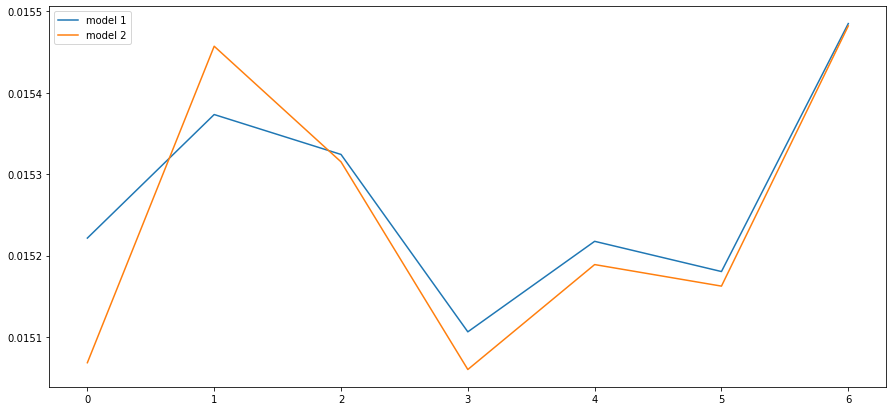

In [94]:
plt.plot(best_losses, label = "model 1")
plt.plot(best_losses_2, label = "model 2")
plt.legend()

In [95]:
def load_fold(fold, select_features = False):

    df = pd.read_csv('../input/lish-moa/train_features.csv')
    df = preprocess(df, select_features = select_features)
    targets_df = pd.read_csv('./train_targets_folds.csv')

    feature_columns = df.drop("sig_id", axis=1).columns
    target_columns = targets_df.drop(["sig_id", "kfold"], axis=1).columns


    df = df.merge(targets_df, on="sig_id", how="left")

    train_df = df[df.kfold != str(fold)].reset_index(drop=True)
    valid_df = df[df.kfold == str(fold)].reset_index(drop=True)

    x_train = train_df[feature_columns].to_numpy()
    y_train = train_df[target_columns].to_numpy()

    x_val = valid_df[feature_columns].to_numpy()
    y_val = valid_df[target_columns].to_numpy()

    return x_train, y_train, x_val, y_val

class blend():
    def __init__(self,all_preds_np):
        
        self.all_preds = all_preds_np
           
    def predict(self, weights):
        self.weights = weights
        final_pred = np.zeros_like(self.all_preds[0])
        
        for i in range(len(self.all_preds)):
            final_pred += self.all_preds[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred


def inference_fn(model, test_features, device):

    results = np.zeros([test_features.shape[0], 206])
    test_features_tensor = torch.tensor(test_features).float().to(device)
    rows = model(test_features_tensor).sigmoid().detach().cpu().numpy()
    results = rows 

    return results 

class pytorch_model():
    def __init__(self, model_class, model_path, device):
        
        self.model_class = model_class
        self.model_path = model_path
        self.device = device
        
        self.model = self.model_class()
        if self.device == "cuda":
            self.model.load_state_dict(torch.load(self.model_path))
        else:
            self.model.load_state_dict(torch.load(self.model_path, map_location=torch.device('cpu') ))

        self.model.to(self.device)
        self.model.eval()
        
    def predict(self, x):
        
        pred = self.model(x)
        
        return pred 
    
    def __call__(self, x):
        return self.predict(x)


def log_loss_metric(y_true, y_pred):
    y_pred_clip = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = - np.mean(np.mean(y_true * np.log(y_pred_clip) + (1 - y_true) * np.log(1 - y_pred_clip), axis = 1))
    return loss

In [98]:
x_train, y_train, x_val, y_val = load_fold("hold", select_features = True)
np.save("hold_labels_785.npy", y_val)
all_preds = []

hold_preds_names =[]
for i in range(7):
    m1  = pytorch_model(Model, "model_"+ str(i) +".pth", device)
    p1 = inference_fn(m1, x_val, device)
    l1 = log_loss_metric(y_val, p1.astype(np.float64))
    print("loss: ", l1, end = "  ")
    all_preds.append(p1)
    
    name = "model_1_hold_"+ str(i) + ".npy"
    np.save(name, p1)
    
    print("saved: ", name)
    
    hold_preds_names.append(name)

loss:  0.015224092514487647  saved:  model_1_hold_0.npy
loss:  0.015239943136893877  saved:  model_1_hold_1.npy
loss:  0.01516410438529617  saved:  model_1_hold_2.npy
loss:  0.015061232235863848  saved:  model_1_hold_3.npy
loss:  0.015126381849161132  saved:  model_1_hold_4.npy
loss:  0.015101584278248387  saved:  model_1_hold_5.npy
loss:  0.015138033755954872  saved:  model_1_hold_6.npy


best loglosses 
```
loss:  0.01518756834039769  saved:  model_1_hold_0.npy
loss:  0.015188967492687305  saved:  model_1_hold_1.npy
loss:  0.01511348981196045  saved:  model_1_hold_2.npy
loss:  0.015109530036842785  saved:  model_1_hold_3.npy
loss:  0.015151522916018512  saved:  model_1_hold_4.npy
loss:  0.01507399836027305  saved:  model_1_hold_5.npy
loss:  0.015221167192909984  saved:  model_1_hold_6.npy

```

In [99]:
x_train, y_train, x_val, y_val = load_fold("hold", select_features = False)
np.save("hold_labels_875.npy", y_val)

for i in range(7):
    m2  = pytorch_model(Model_2, "model_"+ str(i+100) +".pth", device)
    p2 = inference_fn(m2, x_val, device)
    l2 = log_loss_metric(y_val, p2.astype(np.float64))
    print("loss : ", l2, end = "   ")
    all_preds.append(p2)
    
    name = "model_2_hold_"+ str(i) + ".npy"
    np.save(name, p2)
    
    print("saved: ", name)
    hold_preds_names.append(name)

loss :  0.015068140453506544   saved:  model_2_hold_0.npy
loss :  0.015155648214101914   saved:  model_2_hold_1.npy
loss :  0.015169180075420634   saved:  model_2_hold_2.npy
loss :  0.01505862784963318   saved:  model_2_hold_3.npy
loss :  0.015092239975935192   saved:  model_2_hold_4.npy
loss :  0.015075932227196382   saved:  model_2_hold_5.npy
loss :  0.01516164288107469   saved:  model_2_hold_6.npy


In [100]:
def load_test_for_inference_fn(select_features):
    test_df = pd.read_csv("../input/lish-moa/test_features.csv")
    preprocessed_df_test = preprocess(test_df, select_features = select_features)

    test_np = preprocessed_df_test[preprocessed_df_test.columns[1:]].values
    
    return test_np

In [101]:
test_875 = load_test_for_inference_fn(select_features = False)
test_785 = load_test_for_inference_fn(select_features = True)


test_pred_names = []
for i in range(7):
    m  = pytorch_model(Model, "model_"+ str(i) +".pth", device)
    p_test = inference_fn(m, test_785, device)
    name = "model_1_test_"+ str(i) + ".npy"
    np.save(name, p_test)
    print("saved: ", name )
    test_pred_names.append(name)
    
    
for i in range(7):
    m_2  = pytorch_model(Model_2, "model_"+ str(i+100) +".pth", device)
    p_test_2 = inference_fn(m_2, test_875, device)
    name = "model_2_test_"+ str(i) + ".npy"
    np.save(name, p_test_2)
    print("saved: ", name )
    test_pred_names.append(name)

saved:  model_1_test_0.npy
saved:  model_1_test_1.npy
saved:  model_1_test_2.npy
saved:  model_1_test_3.npy
saved:  model_1_test_4.npy
saved:  model_1_test_5.npy
saved:  model_1_test_6.npy
saved:  model_2_test_0.npy
saved:  model_2_test_1.npy
saved:  model_2_test_2.npy
saved:  model_2_test_3.npy
saved:  model_2_test_4.npy
saved:  model_2_test_5.npy
saved:  model_2_test_6.npy


In [ ]:
!zip -r preds.zip *.npy

In [ ]:
hold_preds_names, test_pred_names


In [102]:
hold_labels = np.load("hold_labels_785.npy")
hold_preds = [np.load(name) for name in hold_preds_names]
test_preds = [np.load(name) for name in test_pred_names]

In [103]:
class blend():
    def __init__(self,all_preds_np):
        
        self.all_preds = all_preds_np
           
    def predict(self, weights):
        self.weights = weights
        final_pred = np.zeros_like(self.all_preds[0])
        
        for i in range(len(self.all_preds)):
            final_pred += self.all_preds[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred


In [104]:
def find_loss(params):
    
    threshold = 0.2
    weights_np = np.array(list(params.values()))

    weights_np[weights_np < threshold] = 0
    # print(weights_np)
    blend_boi = blend(hold_preds)
    sample_infer = blend_boi.predict(weights_np)
    
    
    loss = log_loss_metric(hold_labels, sample_infer)
    
    return loss


def objective_blend(trial):

    params = {
        "w1": trial.suggest_uniform("w1", 0.0, 1.0),
        "w2": trial.suggest_uniform("w2", 0.0, 1.0),
        "w3": trial.suggest_uniform("w3", 0.0, 1.0),
        "w4": trial.suggest_uniform("w4", 0.0, 1.0),
        "w5": trial.suggest_uniform("w5", 0.0, 1.0),
        "w6": trial.suggest_uniform("w6", 0.0, 1.0),
        "w7": trial.suggest_uniform("w7", 0.0, 1.0),
        "w8": trial.suggest_uniform("w8", 0.0, 1.0),
        "w9": trial.suggest_uniform("w9", 0.0, 1.0),
        "w10": trial.suggest_uniform("w10", 0.0, 1.0),
        "w11": trial.suggest_uniform("w11", 0.0, 1.0),
        "w12": trial.suggest_uniform("w12", 0.0, 1.0),
        "w13": trial.suggest_uniform("w13", 0.0, 1.0),
        "w14": trial.suggest_uniform("w14", 0.0, 1.0),
    }

    loss_ = find_loss(params) 
    return loss_

In [105]:
len(hold_preds)

14

In [106]:
import optuna

In [107]:
study = optuna.create_study(direction="minimize")

[I 2020-10-14 13:37:27,024] A new study created in memory with name: no-name-4a79c62c-abb0-4a48-b816-cbb22d98c64d


In [110]:
study.optimize(objective_blend, n_trials=1000)

[I 2020-10-14 13:43:18,914] Trial 2000 finished with value: 0.0147615467463733 and parameters: {'w1': 0.21502275391351838, 'w2': 0.18551622372129778, 'w3': 0.001531198050950977, 'w4': 0.8310415892032829, 'w5': 0.31578547194861173, 'w6': 0.141797289998862, 'w7': 0.10878029612953077, 'w8': 0.5463972431203349, 'w9': 0.6351434136916387, 'w10': 0.6300117698303457, 'w11': 0.6225006700655057, 'w12': 0.7036622303122524, 'w13': 0.32785084950839, 'w14': 0.187748381388962}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:19,135] Trial 2001 finished with value: 0.014761580358457798 and parameters: {'w1': 0.2100097694296198, 'w2': 0.16029074679461583, 'w3': 0.07255324227368283, 'w4': 0.8199003534080619, 'w5': 0.2891093240018012, 'w6': 0.19676358787058018, 'w7': 0.08170207811578538, 'w8': 0.5432704588703849, 'w9': 0.6586454863739636, 'w10': 0.6193145376493523, 'w11': 0.5570714301052496, 'w12': 0.680656820674167, 'w13': 0.33086601339530175, 'w14': 0.17359161151468921}. Best i

[I 2020-10-14 13:43:22,514] Trial 2015 finished with value: 0.014766782050887488 and parameters: {'w1': 0.1981409827485549, 'w2': 0.2448922400396072, 'w3': 0.03840581115838186, 'w4': 0.851837790160444, 'w5': 0.26885893002747974, 'w6': 0.24009570044588477, 'w7': 0.5184558676828172, 'w8': 0.5592101113882227, 'w9': 0.6360090138575054, 'w10': 0.6500259776044885, 'w11': 0.616033762947438, 'w12': 0.6934314527243529, 'w13': 0.3268157937287407, 'w14': 0.19302886714079182}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:22,748] Trial 2016 finished with value: 0.014761188588112198 and parameters: {'w1': 0.2039338013449026, 'w2': 0.1849130376234732, 'w3': 0.08245540911289861, 'w4': 0.8263854641312549, 'w5': 0.2890387376288614, 'w6': 0.2685700040042725, 'w7': 0.11235467967568602, 'w8': 0.5404349477470355, 'w9': 0.677630889656283, 'w10': 0.5928532554024002, 'w11': 0.561188576920475, 'w12': 0.7089519461286865, 'w13': 0.30694839183149014, 'w14': 0.16958662070149955}. Best is

[I 2020-10-14 13:43:26,039] Trial 2030 finished with value: 0.014759866517664744 and parameters: {'w1': 0.19606572555721746, 'w2': 0.18903251098530216, 'w3': 0.03902459297303751, 'w4': 0.8198359282052194, 'w5': 0.33420672588129674, 'w6': 0.24215397556392318, 'w7': 0.052715668756846024, 'w8': 0.5336861167236686, 'w9': 0.6928627074177495, 'w10': 0.605691518552484, 'w11': 0.5269631375677158, 'w12': 0.7204956796645842, 'w13': 0.29497086538917794, 'w14': 0.1647910173163531}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:26,280] Trial 2031 finished with value: 0.01476621835308683 and parameters: {'w1': 0.25788198779629684, 'w2': 0.23323866910131633, 'w3': 0.00023449335911515656, 'w4': 0.7700459882932079, 'w5': 0.34194387972589224, 'w6': 0.27120822666737354, 'w7': 0.050502059534307836, 'w8': 0.5449976616269057, 'w9': 0.6932305951755862, 'w10': 0.5771706375069126, 'w11': 0.5357444379192869, 'w12': 0.7057354186942943, 'w13': 0.2958772124297667, 'w14': 0.19612079373265

[I 2020-10-14 13:43:29,873] Trial 2045 finished with value: 0.014760966035782037 and parameters: {'w1': 0.18603619479239714, 'w2': 0.18915070180531304, 'w3': 0.03700172006362715, 'w4': 0.6441306052307321, 'w5': 0.3447283039805227, 'w6': 0.2520195664260585, 'w7': 0.06827997105992774, 'w8': 0.5701081453801563, 'w9': 0.7020214091078416, 'w10': 0.5136448963498412, 'w11': 0.5105762368193469, 'w12': 0.704822285455351, 'w13': 0.3120592890767106, 'w14': 0.14038104362225162}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:30,129] Trial 2046 finished with value: 0.01476371445594312 and parameters: {'w1': 0.18852876842342156, 'w2': 0.20977417301155804, 'w3': 0.04375083907838824, 'w4': 0.8419166868683094, 'w5': 0.30629578506062816, 'w6': 0.27040831647548147, 'w7': 0.052561175713300365, 'w8': 0.5349879194617885, 'w9': 0.672316865226065, 'w10': 0.5717185922310798, 'w11': 0.5508610575702051, 'w12': 0.7258983032095697, 'w13': 0.31170664664900183, 'w14': 0.16500521639846236}. 

[I 2020-10-14 13:43:33,552] Trial 2060 finished with value: 0.014763829173666636 and parameters: {'w1': 0.18304770842777546, 'w2': 0.20779396095155486, 'w3': 0.05143244520390951, 'w4': 0.7981689025264536, 'w5': 0.324939018530506, 'w6': 0.25342066258958607, 'w7': 0.049629632998590294, 'w8': 0.5484337531073162, 'w9': 0.6328279295271898, 'w10': 0.624198721932671, 'w11': 0.5570110571207251, 'w12': 0.6363001385800539, 'w13': 0.30592850876868605, 'w14': 0.18210637267826113}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:33,781] Trial 2061 finished with value: 0.014761666079621476 and parameters: {'w1': 0.20532892159821597, 'w2': 0.18856275607913567, 'w3': 0.019135849780973546, 'w4': 0.7314434823481812, 'w5': 0.35006787748877843, 'w6': 0.23671203825692502, 'w7': 0.08621902576102601, 'w8': 0.5760880408916056, 'w9': 0.68928696780194, 'w10': 0.5762665997113321, 'w11': 0.5285612230728546, 'w12': 0.6901646466088228, 'w13': 0.28716551001877544, 'w14': 0.15859377805288735}

[I 2020-10-14 13:43:37,040] Trial 2075 finished with value: 0.014761214614872379 and parameters: {'w1': 0.20088367749115357, 'w2': 0.16164852531119522, 'w3': 0.055334182420848914, 'w4': 0.7873294051368872, 'w5': 0.28524258499447575, 'w6': 0.2061539586821803, 'w7': 0.049059085546713274, 'w8': 0.5328640015671983, 'w9': 0.7273496308803648, 'w10': 0.5898519899329288, 'w11': 0.525351131214702, 'w12': 0.6936921926929831, 'w13': 0.2854555734156653, 'w14': 0.15002470670885645}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:37,271] Trial 2076 finished with value: 0.014761542371114796 and parameters: {'w1': 0.22315489229453825, 'w2': 0.14843885871204215, 'w3': 0.00017254121099478242, 'w4': 0.782666286302272, 'w5': 0.3129606467098127, 'w6': 0.25168879594357424, 'w7': 0.07166864155538975, 'w8': 0.5737633295743982, 'w9': 0.7029217976698588, 'w10': 0.6060515569870504, 'w11': 0.5487475520540318, 'w12': 0.732346457802505, 'w13': 0.30921404432981053, 'w14': 0.1854065650360540

[I 2020-10-14 13:43:40,871] Trial 2090 finished with value: 0.014760491839693092 and parameters: {'w1': 0.19581152336029517, 'w2': 0.1781066312117238, 'w3': 0.027684232087174104, 'w4': 0.8151353737290828, 'w5': 0.27780889943254344, 'w6': 0.2739049118927797, 'w7': 0.09100326656912235, 'w8': 0.5485151841149227, 'w9': 0.7054526376648583, 'w10': 0.46634516310042134, 'w11': 0.503101103518923, 'w12': 0.7363827277539522, 'w13': 0.284801765972896, 'w14': 0.12363815435291457}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:41,107] Trial 2091 finished with value: 0.014764148831680311 and parameters: {'w1': 0.1797338391743596, 'w2': 0.23830618163892486, 'w3': 0.029984187756409354, 'w4': 0.8441638349116747, 'w5': 0.3484372784712497, 'w6': 0.2384808417492231, 'w7': 0.048581681251083225, 'w8': 0.531571390347551, 'w9': 0.6727049083511615, 'w10': 0.6036528951813172, 'w11': 0.5413848339870146, 'w12': 0.7674289899330337, 'w13': 0.33849293009024667, 'w14': 0.13918274627344301}. 

[I 2020-10-14 13:43:44,752] Trial 2105 finished with value: 0.014760751637375686 and parameters: {'w1': 0.1716523593888466, 'w2': 0.12460232766935078, 'w3': 0.01052164887027951, 'w4': 0.8421819479326987, 'w5': 0.26506029176459206, 'w6': 0.18263024230668332, 'w7': 0.046268455134697385, 'w8': 0.5436599630462317, 'w9': 0.7472886691562832, 'w10': 0.579705654523168, 'w11': 0.46770475127482136, 'w12': 0.7419241947554801, 'w13': 0.3331252225179106, 'w14': 0.07765676700011015}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:45,100] Trial 2106 finished with value: 0.014761807470639468 and parameters: {'w1': 0.20762911832903405, 'w2': 0.1478318094201997, 'w3': 0.0027490836049751527, 'w4': 0.7896987234855761, 'w5': 0.2470448034984462, 'w6': 0.18284282752339165, 'w7': 0.04334279138044755, 'w8': 0.5649229842865643, 'w9': 0.7064498611508746, 'w10': 0.5760885217202192, 'w11': 0.5484026688598268, 'w12': 0.691117303729861, 'w13': 0.3263357215657911, 'w14': 0.12164386908188818}

[I 2020-10-14 13:43:48,530] Trial 2120 finished with value: 0.01476186121797398 and parameters: {'w1': 0.22553498245489512, 'w2': 0.12091768231248395, 'w3': 0.06475279215432093, 'w4': 0.826951920285861, 'w5': 0.2487118702594251, 'w6': 0.18811540057400256, 'w7': 0.06378348990845997, 'w8': 0.5690239797053791, 'w9': 0.6908631562128941, 'w10': 0.5679378775918114, 'w11': 0.5368934792960633, 'w12': 0.7249640398211455, 'w13': 0.33255187834693145, 'w14': 0.1382474393263647}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:48,778] Trial 2121 finished with value: 0.014760559148790613 and parameters: {'w1': 0.16820457280381643, 'w2': 0.13626632824303345, 'w3': 0.06287147754481977, 'w4': 0.8364490071696355, 'w5': 0.2891772341951966, 'w6': 0.19642664603464227, 'w7': 0.046189429905841975, 'w8': 0.5240464644757707, 'w9': 0.7162547822560692, 'w10': 0.5465253782024332, 'w11': 0.511652450582741, 'w12': 0.7429219759149082, 'w13': 0.35934748578818093, 'w14': 0.0973309954859196}. B

[I 2020-10-14 13:43:52,358] Trial 2135 finished with value: 0.01476259328962937 and parameters: {'w1': 0.19423858283811318, 'w2': 0.16072156765064247, 'w3': 0.02834739929269462, 'w4': 0.8411328582425279, 'w5': 0.2650878220609694, 'w6': 0.20613828227226438, 'w7': 0.49504973426899274, 'w8': 0.5653365554243767, 'w9': 0.6823916815783867, 'w10': 0.5946773546081465, 'w11': 0.5449432672106785, 'w12': 0.7482673076592653, 'w13': 0.2744327893306004, 'w14': 0.16050609709812294}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:52,594] Trial 2136 finished with value: 0.014760119635179359 and parameters: {'w1': 0.16332837478762088, 'w2': 0.1453638359856502, 'w3': 0.05336045251032177, 'w4': 0.8547410015502674, 'w5': 0.29806607319583267, 'w6': 0.22517740095869565, 'w7': 0.04078615394198231, 'w8': 0.5841227019063965, 'w9': 0.7060239453172734, 'w10': 0.5692488764163023, 'w11': 0.4993186630649177, 'w12': 0.6753144210221677, 'w13': 0.33936163907875083, 'w14': 0.10025847123401257}.

[I 2020-10-14 13:43:55,923] Trial 2150 finished with value: 0.014759991267740179 and parameters: {'w1': 0.18556893145421835, 'w2': 0.1466548015660296, 'w3': 0.018097369071466557, 'w4': 0.8555832323080804, 'w5': 0.27532545880559733, 'w6': 0.25252284334813335, 'w7': 0.0879208599197729, 'w8': 0.5885083006998036, 'w9': 0.6810925308086525, 'w10': 0.5769097986322874, 'w11': 0.5558625001852635, 'w12': 0.7684431920847177, 'w13': 0.29153128317957244, 'w14': 0.135856918011894}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:56,154] Trial 2151 finished with value: 0.014759905030491845 and parameters: {'w1': 0.16139910212702116, 'w2': 0.17859485838977315, 'w3': 0.07244403097546917, 'w4': 0.8285648997818815, 'w5': 0.2946853581714657, 'w6': 0.217739865284439, 'w7': 0.06553955732253543, 'w8': 0.5717037355844697, 'w9': 0.7107191324111917, 'w10': 0.615169474149036, 'w11': 0.5802987813640698, 'w12': 0.7274661828419151, 'w13': 0.33516055898240393, 'w14': 0.10337333015968804}. Be

[I 2020-10-14 13:43:59,496] Trial 2165 finished with value: 0.014762341578896583 and parameters: {'w1': 0.2395907507718124, 'w2': 0.11794857512173121, 'w3': 0.0604037994621745, 'w4': 0.7814947275627412, 'w5': 0.20205686299203274, 'w6': 0.1669489967202005, 'w7': 0.04225564213034852, 'w8': 0.5229713106360623, 'w9': 0.7495502648924944, 'w10': 0.6073723909578261, 'w11': 0.5302786501447739, 'w12': 0.7036099997047098, 'w13': 0.37333149761486184, 'w14': 0.07169818172885319}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:43:59,734] Trial 2166 finished with value: 0.01476218707142553 and parameters: {'w1': 0.25880635224556436, 'w2': 0.12046274725159684, 'w3': 0.048101439254249395, 'w4': 0.8025595218772074, 'w5': 0.2437000137308421, 'w6': 0.1921391054897833, 'w7': 0.03740469496982267, 'w8': 0.5209500795923585, 'w9': 0.7252839836071168, 'w10': 0.5787511809217893, 'w11': 0.5413473558603568, 'w12': 0.7272604127476515, 'w13': 0.3544984341223289, 'w14': 0.07484583844446963}. B

[I 2020-10-14 13:44:03,433] Trial 2180 finished with value: 0.014759958924262823 and parameters: {'w1': 0.19668799741609205, 'w2': 0.15878361349047218, 'w3': 0.04827079952724647, 'w4': 0.8665462727589751, 'w5': 0.2612599121074723, 'w6': 0.21952133933364834, 'w7': 0.07755684060152297, 'w8': 0.5552752620216413, 'w9': 0.6926361266060026, 'w10': 0.5579454642340527, 'w11': 0.5793283570403857, 'w12': 0.680055254440251, 'w13': 0.32419019062276777, 'w14': 0.09868032665392934}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:44:03,667] Trial 2181 finished with value: 0.014760679061959188 and parameters: {'w1': 0.18833809427592574, 'w2': 0.11619988245801553, 'w3': 0.07096564158629154, 'w4': 0.8204622723244327, 'w5': 0.2846901813071615, 'w6': 0.17850771550066888, 'w7': 0.04200921487942179, 'w8': 0.5405016722021949, 'w9': 0.7257367605443431, 'w10': 0.6074960480460143, 'w11': 0.5121660740183963, 'w12': 0.6631735981708445, 'w13': 0.383448778676004, 'w14': 0.11483071687302716}. 

[I 2020-10-14 13:44:07,097] Trial 2195 finished with value: 0.01476036604255285 and parameters: {'w1': 0.17404788891036876, 'w2': 0.12863465498879306, 'w3': 0.04675763004947349, 'w4': 0.84713532222854, 'w5': 0.31841605096612524, 'w6': 0.1949291954665237, 'w7': 0.09426607173300691, 'w8': 0.5250707634086692, 'w9': 0.6937677636918584, 'w10': 0.6359110740168116, 'w11': 0.5219515079616156, 'w12': 0.7542092464467856, 'w13': 0.36032480657994964, 'w14': 0.12280620018935587}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:44:07,334] Trial 2196 finished with value: 0.014761944606010588 and parameters: {'w1': 0.24288866531099085, 'w2': 0.11399942558849328, 'w3': 0.017287652786920633, 'w4': 0.8288078446079005, 'w5': 0.31783345632768234, 'w6': 0.17480066861710053, 'w7': 0.10248628853499217, 'w8': 0.5168507090019514, 'w9': 0.6708690025407376, 'w10': 0.6241764365253382, 'w11': 0.5076096447301528, 'w12': 0.7668550025085933, 'w13': 0.38909087946895665, 'w14': 0.12688716958774238}

[I 2020-10-14 13:44:10,851] Trial 2210 finished with value: 0.014761811462343935 and parameters: {'w1': 0.23062944013190184, 'w2': 0.13179865286733117, 'w3': 0.03074674067605709, 'w4': 0.8720833777620643, 'w5': 0.3216962503277017, 'w6': 0.17783803001648169, 'w7': 0.08088678966442364, 'w8': 0.5167249239518801, 'w9': 0.7259070291534142, 'w10': 0.6247862635410181, 'w11': 0.4720257743776816, 'w12': 0.7482435403577623, 'w13': 0.3624786022598969, 'w14': 0.1560373187600264}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:44:11,398] Trial 2211 finished with value: 0.01475999479305065 and parameters: {'w1': 0.19253132804013873, 'w2': 0.11912911803002914, 'w3': 0.053636597200908145, 'w4': 0.808082092591096, 'w5': 0.31535735466914794, 'w6': 0.206473135144213, 'w7': 0.03973449674575249, 'w8': 0.5151166794320766, 'w9': 0.7172223900330946, 'w10': 0.5992816046989081, 'w11': 0.5152329282885082, 'w12': 0.7699384916065546, 'w13': 0.34736137530363165, 'w14': 0.11269332439268732}. B

[I 2020-10-14 13:44:15,257] Trial 2225 finished with value: 0.014760555147369637 and parameters: {'w1': 0.1714318761450293, 'w2': 0.15418783779177475, 'w3': 0.03447229402174484, 'w4': 0.772706094586197, 'w5': 0.3200066687490822, 'w6': 0.1839826497075686, 'w7': 0.0791166630843225, 'w8': 0.5188398388614518, 'w9': 0.7087048376549137, 'w10': 0.6211651813520004, 'w11': 0.5464061509856909, 'w12': 0.7355444078927135, 'w13': 0.35631358009423747, 'w14': 0.1934223063629887}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:44:15,498] Trial 2226 finished with value: 0.014764046825112656 and parameters: {'w1': 0.22667222148020502, 'w2': 0.1402547097850863, 'w3': 0.06117563101859423, 'w4': 0.8797710670520892, 'w5': 0.2935696944862168, 'w6': 0.2101304666203546, 'w7': 0.10937163557926306, 'w8': 0.5552883691525988, 'w9': 0.7374213430807145, 'w10': 0.6417907278153587, 'w11': 0.5533045865652435, 'w12': 0.7709489224471735, 'w13': 0.8222081142251014, 'w14': 0.1575886146685193}. Best i

[I 2020-10-14 13:44:19,880] Trial 2240 finished with value: 0.014763611089529593 and parameters: {'w1': 0.23132560784774636, 'w2': 0.13465006490192943, 'w3': 0.0011560310093590986, 'w4': 0.8701703803834944, 'w5': 0.2745814630339713, 'w6': 0.2431649077950977, 'w7': 0.37628709989819065, 'w8': 0.5259750223730172, 'w9': 0.6584538866450678, 'w10': 0.560739708730822, 'w11': 0.5089036606516495, 'w12': 0.6427394250333278, 'w13': 0.36377192773640116, 'w14': 0.16179655378796734}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:44:20,198] Trial 2241 finished with value: 0.014762158943730154 and parameters: {'w1': 0.25241913076722583, 'w2': 0.11411655188106945, 'w3': 0.0027089810194009765, 'w4': 0.883591543703147, 'w5': 0.3298276398580721, 'w6': 0.2505750312432965, 'w7': 0.1219646044785188, 'w8': 0.5198466901128141, 'w9': 0.6511914311018796, 'w10': 0.5400721985455008, 'w11': 0.4889672865203356, 'w12': 0.6718193014637417, 'w13': 0.4028634330105225, 'w14': 0.1728130095018689}. 

[I 2020-10-14 13:44:24,344] Trial 2255 finished with value: 0.014771170629583144 and parameters: {'w1': 0.2064301556824969, 'w2': 0.1470452486284044, 'w3': 0.02063114150726712, 'w4': 0.8804009927723317, 'w5': 0.2552803163644509, 'w6': 0.27594513027732415, 'w7': 0.04988208936397022, 'w8': 0.516217520479073, 'w9': 0.673077910316286, 'w10': 0.10601534566540632, 'w11': 0.4557323493706792, 'w12': 0.6979235069497841, 'w13': 0.2984597683005384, 'w14': 0.16820911222097001}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:44:24,608] Trial 2256 finished with value: 0.01476004370177674 and parameters: {'w1': 0.19361378479721214, 'w2': 0.1658517272799774, 'w3': 0.0418649900510877, 'w4': 0.866315960453215, 'w5': 0.23233658366127616, 'w6': 0.2441030455457157, 'w7': 0.032830625796995735, 'w8': 0.5107584004992396, 'w9': 0.68000945046602, 'w10': 0.5809708601804373, 'w11': 0.5306308371396724, 'w12': 0.6442201410252799, 'w13': 0.32712154539587107, 'w14': 0.16130034547729072}. Best i

[I 2020-10-14 13:44:28,264] Trial 2270 finished with value: 0.014760148167862006 and parameters: {'w1': 0.17956141016635566, 'w2': 0.12373222860945304, 'w3': 0.041202505167836426, 'w4': 0.8923040569901501, 'w5': 0.2582322131839296, 'w6': 0.20219392184105806, 'w7': 0.03801786966690701, 'w8': 0.5291987376792096, 'w9': 0.655422185950385, 'w10': 0.5618135580497647, 'w11': 0.42767880332777, 'w12': 0.7123748809545692, 'w13': 0.34169232391181936, 'w14': 0.15126704397194873}. Best is trial 1992 with value: 0.014759797189284976.
[I 2020-10-14 13:44:28,504] Trial 2271 finished with value: 0.014761651643753128 and parameters: {'w1': 0.24130681568057066, 'w2': 0.14614363821207993, 'w3': 0.0707244397908144, 'w4': 0.8654838468216145, 'w5': 0.28935995288016175, 'w6': 0.224616312118739, 'w7': 0.03244012318948733, 'w8': 0.5343859322463469, 'w9': 0.6714118204064726, 'w10': 0.5209313676465915, 'w11': 0.5164469607365785, 'w12': 0.7738677091825523, 'w13': 0.31144499874761883, 'w14': 0.18529528893591524}. B

[I 2020-10-14 13:44:31,927] Trial 2285 finished with value: 0.01476044525460622 and parameters: {'w1': 0.1813278636913859, 'w2': 0.09907504847824328, 'w3': 0.07448986225007997, 'w4': 0.8584810796554563, 'w5': 0.2514311771934904, 'w6': 0.18747120731008174, 'w7': 0.03182599376219139, 'w8': 0.5033245657537155, 'w9': 0.6475191548367861, 'w10': 0.5430961386514627, 'w11': 0.5342409223866005, 'w12': 0.7699087659020996, 'w13': 0.3458910442912153, 'w14': 0.1635525405467811}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:44:32,166] Trial 2286 finished with value: 0.014772002798980891 and parameters: {'w1': 0.21361835853913647, 'w2': 0.10820096994591433, 'w3': 0.08223407852937953, 'w4': 0.8745015967228962, 'w5': 0.23356026105157562, 'w6': 0.2141161575089535, 'w7': 0.05896213541818236, 'w8': 0.5196399898411251, 'w9': 0.17814507259138102, 'w10': 0.5741040384173386, 'w11': 0.5450834708749276, 'w12': 0.7575691719741415, 'w13': 0.32206354783451685, 'w14': 0.1657416007942023}. B

[I 2020-10-14 13:44:36,288] Trial 2300 finished with value: 0.01476005884058256 and parameters: {'w1': 0.19039501968294223, 'w2': 0.06964743463751497, 'w3': 0.04563874177132914, 'w4': 0.8592756579002869, 'w5': 0.24073104766752185, 'w6': 0.24913094864344426, 'w7': 0.05473780566969248, 'w8': 0.5187601316027681, 'w9': 0.6083823322321554, 'w10': 0.5536158718211439, 'w11': 0.5443175011909179, 'w12': 0.7780615789117484, 'w13': 0.3150509682311575, 'w14': 0.1979067338166819}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:44:36,560] Trial 2301 finished with value: 0.014761759491533863 and parameters: {'w1': 0.2585214104746055, 'w2': 0.08139983462992736, 'w3': 0.06495653116145937, 'w4': 0.8970312334634767, 'w5': 0.26290325301558465, 'w6': 0.2148412324511683, 'w7': 0.09363406251079344, 'w8': 0.5152212742689453, 'w9': 0.6243643330565509, 'w10': 0.5699103394079442, 'w11': 0.513647147032592, 'w12': 0.7521231913117279, 'w13': 0.34212754154853053, 'w14': 0.18920435753058717}. B

[I 2020-10-14 13:44:40,207] Trial 2315 finished with value: 0.014764708916862315 and parameters: {'w1': 0.19833266861385226, 'w2': 0.10461961830497896, 'w3': 0.016616598623089705, 'w4': 0.8674010416428323, 'w5': 0.2348938363802586, 'w6': 0.27862562510067634, 'w7': 0.5891198953051261, 'w8': 0.5063865068451233, 'w9': 0.6305460101446267, 'w10': 0.5805131568313179, 'w11': 0.5224742775640129, 'w12': 0.7524583891999705, 'w13': 0.34314514411398217, 'w14': 0.2186611830961666}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:44:40,454] Trial 2316 finished with value: 0.01476152272897255 and parameters: {'w1': 0.23770962852701108, 'w2': 0.06783760475933762, 'w3': 0.03848696502463901, 'w4': 0.8878540264223624, 'w5': 0.2734769171344986, 'w6': 0.24377409659556068, 'w7': 0.029404681200954907, 'w8': 0.5258361071092995, 'w9': 0.623838311859432, 'w10': 0.5480084404947132, 'w11': 0.5614964831923054, 'w12': 0.7463047510946068, 'w13': 0.3134581369043951, 'w14': 0.17407862116154482}. 

[I 2020-10-14 13:44:43,918] Trial 2330 finished with value: 0.014761336037429714 and parameters: {'w1': 0.20841268636151136, 'w2': 0.08261316804680417, 'w3': 0.016995174207665917, 'w4': 0.8999560473703345, 'w5': 0.2929173166173323, 'w6': 0.21779492770747472, 'w7': 0.05568263767540767, 'w8': 0.5122188151245298, 'w9': 0.6425941283543999, 'w10': 0.5677268562434482, 'w11': 0.5524912449670768, 'w12': 0.7455157395660011, 'w13': 0.3497266106784234, 'w14': 0.2242080083085482}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:44:44,321] Trial 2331 finished with value: 0.014759973240718741 and parameters: {'w1': 0.18126271406390612, 'w2': 0.08812195380301435, 'w3': 0.03823356385162227, 'w4': 0.8755588026631407, 'w5': 0.2687615557048128, 'w6': 0.27685840220162644, 'w7': 0.051775261972849373, 'w8': 0.5313813601089228, 'w9': 0.6331951381328814, 'w10': 0.5670061756279235, 'w11': 0.5695250508998594, 'w12': 0.7324217930918726, 'w13': 0.3125424503445604, 'w14': 0.15775103553197853}

[I 2020-10-14 13:44:47,994] Trial 2345 finished with value: 0.014759945995706906 and parameters: {'w1': 0.19471929501217666, 'w2': 0.08806573549368255, 'w3': 0.03841990846856661, 'w4': 0.8264369190080676, 'w5': 0.28044346290167466, 'w6': 0.22243309432036548, 'w7': 0.09069692242834568, 'w8': 0.5345739381597231, 'w9': 0.6621590604799478, 'w10': 0.5553296043294865, 'w11': 0.5408823051720738, 'w12': 0.7080778721119164, 'w13': 0.3475528780597164, 'w14': 0.17415941673109359}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:44:48,271] Trial 2346 finished with value: 0.014760412458248752 and parameters: {'w1': 0.17383084931074816, 'w2': 0.09312651655489929, 'w3': 0.05866677407088969, 'w4': 0.8550773367546436, 'w5': 0.23601735535725235, 'w6': 0.18512350848694464, 'w7': 0.07301633294680218, 'w8': 0.5117856390118206, 'w9': 0.6612940896421828, 'w10': 0.5715908488923884, 'w11': 0.5520050127656537, 'w12': 0.7322390015348443, 'w13': 0.3438362145471677, 'w14': 0.15275702824780885

[I 2020-10-14 13:44:52,470] Trial 2360 finished with value: 0.014760334560413417 and parameters: {'w1': 0.15829381431751727, 'w2': 0.03059578428275342, 'w3': 0.08518035354255302, 'w4': 0.8123397258092073, 'w5': 0.2822126894807346, 'w6': 0.17865442145308655, 'w7': 0.11977845790687924, 'w8': 0.5127411139302015, 'w9': 0.6449098295201552, 'w10': 0.5978908876943698, 'w11': 0.5574765081093661, 'w12': 0.717522762617263, 'w13': 0.3555845434373906, 'w14': 0.18468732463052012}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:44:52,712] Trial 2361 finished with value: 0.014764617475855666 and parameters: {'w1': 0.15460363578444059, 'w2': 0.050380396799868665, 'w3': 0.07208652765640385, 'w4': 0.8447963987074091, 'w5': 0.9603065379176616, 'w6': 0.2154719750752002, 'w7': 0.08785691724346165, 'w8': 0.5459361487850674, 'w9': 0.6696505994739921, 'w10': 0.5974366902408808, 'w11': 0.5633621212682745, 'w12': 0.7557182312589279, 'w13': 0.3485870782073414, 'w14': 0.19658922869434753}. 

[I 2020-10-14 13:44:56,558] Trial 2375 finished with value: 0.014760402056907327 and parameters: {'w1': 0.1510038754056388, 'w2': 0.07595333045338311, 'w3': 0.019764581065705056, 'w4': 0.8283314729084219, 'w5': 0.31669152998724953, 'w6': 0.02771979803518876, 'w7': 0.08502563083155688, 'w8': 0.5169997366271815, 'w9': 0.657952651063524, 'w10': 0.5659364249623677, 'w11': 0.5615397474417917, 'w12': 0.773473896313221, 'w13': 0.3673000316885945, 'w14': 0.16527116313239712}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:44:56,814] Trial 2376 finished with value: 0.014761845751543084 and parameters: {'w1': 0.2002870399096781, 'w2': 0.077747547725526, 'w3': 0.04589030989880906, 'w4': 0.815036635485466, 'w5': 0.2660590150513336, 'w6': 0.2768086209829613, 'w7': 0.07730665539021367, 'w8': 0.4898371572043562, 'w9': 0.603643560668885, 'w10': 0.590811106270104, 'w11': 0.5847474527142534, 'w12': 0.6895105032331723, 'w13': 0.423951468448887, 'w14': 0.21737600318407085}. Best is 

[I 2020-10-14 13:45:00,300] Trial 2390 finished with value: 0.014766340395117079 and parameters: {'w1': 0.16117126697737993, 'w2': 0.052993949070742404, 'w3': 0.06233534589359585, 'w4': 0.838212874206863, 'w5': 0.17304464678983783, 'w6': 0.7373377387323005, 'w7': 0.13295080267827653, 'w8': 0.49228962943292304, 'w9': 0.6030319079157772, 'w10': 0.5880266234256528, 'w11': 0.5885417624721868, 'w12': 0.7563689179632666, 'w13': 0.3727653200453183, 'w14': 0.1663609891650962}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:00,543] Trial 2391 finished with value: 0.014764776462099763 and parameters: {'w1': 0.21104332082353003, 'w2': 0.07786676726953033, 'w3': 0.08431515140733223, 'w4': 0.8778228468076247, 'w5': 0.2526957229963342, 'w6': 0.6971022931333929, 'w7': 0.07750566072777908, 'w8': 0.48998402931700397, 'w9': 0.6432000671596544, 'w10': 0.5595931158570587, 'w11': 0.555444235068141, 'w12': 0.7414938845881491, 'w13': 0.3625740049871999, 'w14': 0.2052369793387796}. B

[I 2020-10-14 13:45:04,027] Trial 2405 finished with value: 0.014762161906086877 and parameters: {'w1': 0.14868168959009218, 'w2': 0.09732696908477811, 'w3': 0.03424671969561573, 'w4': 0.839968888441459, 'w5': 0.20184917503233263, 'w6': 0.23655686774824808, 'w7': 0.11701836434962809, 'w8': 0.5298576217106138, 'w9': 0.6260788481317264, 'w10': 0.6097885850073294, 'w11': 0.5707849495867717, 'w12': 0.3515357529047828, 'w13': 0.38297578445059816, 'w14': 0.20439605360766017}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:04,276] Trial 2406 finished with value: 0.014759814203807538 and parameters: {'w1': 0.18397420728940175, 'w2': 0.09476784704392163, 'w3': 0.08581992578091822, 'w4': 0.8778713143819118, 'w5': 0.27389095233683336, 'w6': 0.20985976550039048, 'w7': 0.10207822657575795, 'w8': 0.5102993923671959, 'w9': 0.6728853532481469, 'w10': 0.5846202340461712, 'w11': 0.5472134446205876, 'w12': 0.7781984575091199, 'w13': 0.33004664445078336, 'w14': 0.1405804380089075

[I 2020-10-14 13:45:08,048] Trial 2420 finished with value: 0.014761746613599252 and parameters: {'w1': 0.18490157718945582, 'w2': 0.03739058207284654, 'w3': 0.04442604280835587, 'w4': 0.8678203576161672, 'w5': 0.3035986499962883, 'w6': 0.5062498845693528, 'w7': 0.15516964217993973, 'w8': 0.5225506851265146, 'w9': 0.6163018745741065, 'w10': 0.5594196424369746, 'w11': 0.5179154519514236, 'w12': 0.7813819202422071, 'w13': 0.3791572440332225, 'w14': 0.14246751961698506}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:08,303] Trial 2421 finished with value: 0.014761751535802621 and parameters: {'w1': 0.22887687250351568, 'w2': 0.09798861133470874, 'w3': 0.08756431501753678, 'w4': 0.8182890202389738, 'w5': 0.24566116896090534, 'w6': 0.1872184283651036, 'w7': 0.10697779444240575, 'w8': 0.5304380678689595, 'w9': 0.6427387514853369, 'w10': 0.5902929703657436, 'w11': 0.5453807364251096, 'w12': 0.7599092801343229, 'w13': 0.32813904923925824, 'w14': 0.16371479212992338}.

[I 2020-10-14 13:45:12,531] Trial 2435 finished with value: 0.014762143204983834 and parameters: {'w1': 0.2753163219981628, 'w2': 0.0417510329402441, 'w3': 0.06996220782661047, 'w4': 0.8845391312748332, 'w5': 0.26433475500916986, 'w6': 0.21197861464227838, 'w7': 0.08712640445071418, 'w8': 0.4952668011083797, 'w9': 0.6340683991321134, 'w10': 0.614262792689911, 'w11': 0.5256642955153192, 'w12': 0.6052052573380912, 'w13': 0.3454865353137638, 'w14': 0.13971603352382683}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:12,804] Trial 2436 finished with value: 0.014760447311232836 and parameters: {'w1': 0.19707690047452056, 'w2': 0.06218157359161646, 'w3': 0.053063693911135884, 'w4': 0.7968349876943567, 'w5': 0.3302761425784209, 'w6': 0.15983030153457572, 'w7': 0.06530452133819824, 'w8': 0.5134204831863523, 'w9': 0.6734955311890953, 'w10': 0.6181503749849311, 'w11': 0.5614755372843867, 'w12': 0.6542815979956564, 'w13': 0.3682262456036972, 'w14': 0.1859640285829391}. B

[I 2020-10-14 13:45:16,547] Trial 2450 finished with value: 0.014759854080894337 and parameters: {'w1': 0.15289444028964763, 'w2': 0.101396353790409, 'w3': 0.06509414769089716, 'w4': 0.882151306823765, 'w5': 0.3274900550849773, 'w6': 0.22017908281547938, 'w7': 0.10069115952047829, 'w8': 0.5059236270024343, 'w9': 0.680069762277373, 'w10': 0.5928117393575123, 'w11': 0.5330322510432605, 'w12': 0.7026565653745189, 'w13': 0.3656317327131265, 'w14': 0.15924178090561888}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:16,796] Trial 2451 finished with value: 0.014761731013728591 and parameters: {'w1': 0.15501441346044884, 'w2': 0.07295503322579765, 'w3': 0.03381521331542018, 'w4': 0.8899224168684299, 'w5': 0.3305156911865198, 'w6': 0.4767544282064163, 'w7': 0.1150025449705997, 'w8': 0.48371721304972265, 'w9': 0.6412651365037448, 'w10': 0.5712896394645279, 'w11': 0.5012574338267631, 'w12': 0.6591270735812603, 'w13': 0.4413791169015469, 'w14': 0.19894004120889383}. Best

[I 2020-10-14 13:45:20,790] Trial 2465 finished with value: 0.014760185775949354 and parameters: {'w1': 0.16676472080535695, 'w2': 0.01457254059278855, 'w3': 0.06801236602635642, 'w4': 0.8569967750125287, 'w5': 0.33613566156470676, 'w6': 0.22629577311878452, 'w7': 0.13207993700532514, 'w8': 0.5388733144548215, 'w9': 0.6812675281924974, 'w10': 0.5598299392876067, 'w11': 0.5094462348063828, 'w12': 0.6815559992346167, 'w13': 0.3572731777156877, 'w14': 0.21315981707811016}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:21,043] Trial 2466 finished with value: 0.014759851149383118 and parameters: {'w1': 0.18107737379435218, 'w2': 0.10088861948219024, 'w3': 0.0009789001618505744, 'w4': 0.8851581877869674, 'w5': 0.3121860056530306, 'w6': 0.24712725323341916, 'w7': 0.09759387055571142, 'w8': 0.4809822493844603, 'w9': 0.6574540152163068, 'w10': 0.5940474241246269, 'w11': 0.5623438880990729, 'w12': 0.7009142847339283, 'w13': 0.3566682325586441, 'w14': 0.1549294046930223

[I 2020-10-14 13:45:25,086] Trial 2480 finished with value: 0.014760335467433995 and parameters: {'w1': 0.14328725261269298, 'w2': 0.08406639627771374, 'w3': 0.0004967534604498518, 'w4': 0.8982571724755507, 'w5': 0.27637406929542163, 'w6': 0.18598582015673934, 'w7': 0.0979470900090446, 'w8': 0.5032940520861154, 'w9': 0.6349488647033885, 'w10': 0.5916632670052515, 'w11': 0.5661903827260196, 'w12': 0.7082431947876137, 'w13': 0.379285440993729, 'w14': 0.1348473784664169}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:25,335] Trial 2481 finished with value: 0.014760080946029906 and parameters: {'w1': 0.18791243624638793, 'w2': 0.10077096761125208, 'w3': 0.034132744692867166, 'w4': 0.8674352791216795, 'w5': 0.29255178150718053, 'w6': 0.2583266085833577, 'w7': 0.11851859038984866, 'w8': 0.4720668997111592, 'w9': 0.6014548197526768, 'w10': 0.5294314722173001, 'w11': 0.5450737703291992, 'w12': 0.6830072028459587, 'w13': 0.3529324211985193, 'w14': 0.15490233903731543}

[I 2020-10-14 13:45:29,168] Trial 2495 finished with value: 0.014760425610033798 and parameters: {'w1': 0.14718545689603105, 'w2': 0.04884804216351789, 'w3': 0.03635206958298948, 'w4': 0.8470377318591887, 'w5': 0.27306180918962686, 'w6': 0.15486267026709777, 'w7': 0.0815198566447043, 'w8': 0.5163087825688221, 'w9': 0.5970229137394759, 'w10': 0.6242929868613907, 'w11': 0.48766224787017187, 'w12': 0.6610059338623973, 'w13': 0.34551130993623363, 'w14': 0.1398853331888702}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:29,426] Trial 2496 finished with value: 0.014759932938896842 and parameters: {'w1': 0.16559949318396974, 'w2': 0.0897907486274783, 'w3': 0.05366393297403856, 'w4': 0.8772814216215757, 'w5': 0.2717028822218507, 'w6': 0.2423718859105163, 'w7': 0.11372464651190563, 'w8': 0.5079256225171723, 'w9': 0.6430111603544473, 'w10': 0.5981774990341113, 'w11': 0.551381957912245, 'w12': 0.6919485965062947, 'w13': 0.36659339203763847, 'w14': 0.15338696083423967}. 

[I 2020-10-14 13:45:33,030] Trial 2510 finished with value: 0.01476816301609279 and parameters: {'w1': 0.17359897582182734, 'w2': 0.08980387841590834, 'w3': 0.42135785787294966, 'w4': 0.8839421903901045, 'w5': 0.23082235620668023, 'w6': 0.24012132213267548, 'w7': 0.11338664697768162, 'w8': 0.4846120364707783, 'w9': 0.629314542163835, 'w10': 0.582003824086769, 'w11': 0.5115675933755988, 'w12': 0.7092106140533507, 'w13': 0.35674228128643404, 'w14': 0.21206957797150017}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:33,288] Trial 2511 finished with value: 0.014782913068181051 and parameters: {'w1': 0.1387936406910771, 'w2': 0.04098570670208537, 'w3': 0.9968608135184004, 'w4': 0.8650655204122779, 'w5': 0.23570941588308061, 'w6': 0.11523716816114328, 'w7': 0.12759581462268324, 'w8': 0.464564465417749, 'w9': 0.6479832729462114, 'w10': 0.5563604478792014, 'w11': 0.5568607109998055, 'w12': 0.7296380958285461, 'w13': 0.38771650416162345, 'w14': 0.1987350610428495}. Be

[I 2020-10-14 13:45:37,032] Trial 2525 finished with value: 0.014760477733969313 and parameters: {'w1': 0.193900852288722, 'w2': 0.10766787947241807, 'w3': 0.0004970315281001211, 'w4': 0.6944776980010027, 'w5': 0.25731410328970455, 'w6': 0.23325865253776767, 'w7': 0.09083572699935569, 'w8': 0.5164509551566686, 'w9': 0.6248063333181446, 'w10': 0.5490421995377662, 'w11': 0.49067098200577813, 'w12': 0.740802768695201, 'w13': 0.35456955836436677, 'w14': 0.18560521966812218}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:37,291] Trial 2526 finished with value: 0.014759970855644277 and parameters: {'w1': 0.1734173008057696, 'w2': 0.08090788616408127, 'w3': 0.06875922927961968, 'w4': 0.8373509744484736, 'w5': 0.2647124651652534, 'w6': 0.27599127107378557, 'w7': 0.1087837975662221, 'w8': 0.5069259758700533, 'w9': 0.6594532176765288, 'w10': 0.609566876930915, 'w11': 0.5229619345694237, 'w12': 0.715811299164821, 'w13': 0.3292955237992231, 'w14': 0.1636997842059972}. Be

[I 2020-10-14 13:45:41,230] Trial 2540 finished with value: 0.014760064958166024 and parameters: {'w1': 0.14280553368385238, 'w2': 0.08528398736932459, 'w3': 0.090747129396101, 'w4': 0.8890843365058217, 'w5': 0.2367401134264978, 'w6': 0.2562509909294405, 'w7': 0.09940628170991452, 'w8': 0.5225556290230774, 'w9': 0.6196552239509697, 'w10': 0.5678995576013915, 'w11': 0.5747248343421547, 'w12': 0.7504066269348938, 'w13': 0.3453554520468305, 'w14': 0.16186248417887591}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:41,496] Trial 2541 finished with value: 0.014760878072613006 and parameters: {'w1': 0.16372545425825769, 'w2': 0.05894471954460767, 'w3': 0.054829002491310466, 'w4': 0.6586235491757717, 'w5': 0.21134620843075902, 'w6': 0.2344984083687022, 'w7': 0.07106068850053647, 'w8': 0.4593660318958812, 'w9': 0.6681240351967364, 'w10': 0.6037354902047725, 'w11': 0.5429132129812699, 'w12': 0.7332003567327152, 'w13': 0.39867523784792663, 'w14': 0.13754536864336886}. 

[I 2020-10-14 13:45:45,202] Trial 2555 finished with value: 0.014761985413000356 and parameters: {'w1': 0.15893842697519905, 'w2': 0.09111586954271973, 'w3': 0.047761616493429485, 'w4': 0.9064246117726117, 'w5': 0.24539735356165282, 'w6': 0.20818739490674962, 'w7': 0.42711844641410524, 'w8': 0.512549245693336, 'w9': 0.644001957109819, 'w10': 0.5803655401776767, 'w11': 0.5307848012429734, 'w12': 0.719025708005757, 'w13': 0.34199061925786683, 'w14': 0.1512647458360389}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:45,457] Trial 2556 finished with value: 0.014763414350242237 and parameters: {'w1': 0.20151882345209157, 'w2': 0.11171672383870286, 'w3': 0.09036647043305515, 'w4': 0.8355325216831162, 'w5': 0.09463755321102374, 'w6': 0.22893568568220804, 'w7': 0.113647515333929, 'w8': 0.4869929737221993, 'w9': 0.6762002910466769, 'w10': 0.6091536916284811, 'w11': 0.4732442442034392, 'w12': 0.6755541317331114, 'w13': 0.40900410507171475, 'w14': 0.13374096295080262}. 

[I 2020-10-14 13:45:49,042] Trial 2570 finished with value: 0.014760109947973119 and parameters: {'w1': 0.13459146080835707, 'w2': 0.09086759386420765, 'w3': 0.01863118214778265, 'w4': 0.8698050039127943, 'w5': 0.2060877103742245, 'w6': 0.20586125901521182, 'w7': 0.08449639332198487, 'w8': 0.5261618510414987, 'w9': 0.6614472150617927, 'w10': 0.5865299565994798, 'w11': 0.5502489389222764, 'w12': 0.6774602942471845, 'w13': 0.36805796020803344, 'w14': 0.17205977134387151}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:49,301] Trial 2571 finished with value: 0.014765192973559181 and parameters: {'w1': 0.5196338957428475, 'w2': 0.06370400409604607, 'w3': 0.07396233752050685, 'w4': 0.88853105894509, 'w5': 0.2760705390564411, 'w6': 0.2755630360313183, 'w7': 0.059135684180718726, 'w8': 0.5031219892877928, 'w9': 0.6274703842768924, 'w10': 0.6312301853286745, 'w11': 0.5905987896966722, 'w12': 0.7825018611863257, 'w13': 0.34376152389818027, 'w14': 0.21246207448397977}. 

[I 2020-10-14 13:45:53,264] Trial 2585 finished with value: 0.01476160155791247 and parameters: {'w1': 0.2510899780307908, 'w2': 0.11427552361718729, 'w3': 0.04157855752827316, 'w4': 0.9097721271792247, 'w5': 0.2658569755771636, 'w6': 0.2321325233245541, 'w7': 0.11344842116402463, 'w8': 0.5452892721513181, 'w9': 0.6768011929688704, 'w10': 0.6409219286816672, 'w11': 0.5316238985712832, 'w12': 0.6907528336629822, 'w13': 0.3138133115935818, 'w14': 0.148324116270929}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:53,522] Trial 2586 finished with value: 0.014759948149952587 and parameters: {'w1': 0.18618083645408176, 'w2': 0.06596298130095407, 'w3': 0.018702566760224526, 'w4': 0.8854370832389057, 'w5': 0.2912573926804024, 'w6': 0.25917012711656834, 'w7': 0.1058087761228167, 'w8': 0.5234858497681505, 'w9': 0.6849866499669823, 'w10': 0.5942357120828371, 'w11': 0.5402236955559218, 'w12': 0.6560155218782509, 'w13': 0.3335165334611571, 'w14': 0.12689341944894758}. Best

[I 2020-10-14 13:45:57,744] Trial 2600 finished with value: 0.014759883378304558 and parameters: {'w1': 0.19039110346776325, 'w2': 0.09822286999618063, 'w3': 0.0006588072982266005, 'w4': 0.8608507501109672, 'w5': 0.32150727926444084, 'w6': 0.20479583792102063, 'w7': 0.10104715911149421, 'w8': 0.5172939375258672, 'w9': 0.6495122345911928, 'w10': 0.5294650584161145, 'w11': 0.5439682369898508, 'w12': 0.7163747571980361, 'w13': 0.3291641241230943, 'w14': 0.17790816171545465}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:45:58,013] Trial 2601 finished with value: 0.014767926500869723 and parameters: {'w1': 0.6462957783251556, 'w2': 0.09759015664324718, 'w3': 0.06742510282152994, 'w4': 0.8316547159578555, 'w5': 0.30081935630742945, 'w6': 0.2272398666461696, 'w7': 0.14604649387847846, 'w8': 0.5303581909584324, 'w9': 0.693034277408527, 'w10': 0.5816861549464061, 'w11': 0.5244471225684184, 'w12': 0.678013051552085, 'w13': 0.3142641898008555, 'w14': 0.14366358013878347}.

[I 2020-10-14 13:46:02,033] Trial 2615 finished with value: 0.014764180434114569 and parameters: {'w1': 0.18094485644167355, 'w2': 0.0958892745687638, 'w3': 0.05364820369312218, 'w4': 0.9093520751401929, 'w5': 0.2870106497992969, 'w6': 0.7721963039133057, 'w7': 0.1423825196037753, 'w8': 0.5306513447254199, 'w9': 0.6912630910934101, 'w10': 0.6012216839175447, 'w11': 0.5121122892583576, 'w12': 0.6985442878881399, 'w13': 0.3535447222829343, 'w14': 0.1475920007784254}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:02,305] Trial 2616 finished with value: 0.01476147454501616 and parameters: {'w1': 0.20277865843469794, 'w2': 0.07385750891408946, 'w3': 0.03589337280157096, 'w4': 0.8515308541873259, 'w5': 0.27966465740498236, 'w6': 0.19735071690747136, 'w7': 0.17417199406156486, 'w8': 0.49683651173248583, 'w9': 0.6477636402666802, 'w10': 0.6262089799507637, 'w11': 0.4846964549911519, 'w12': 0.7156049130597684, 'w13': 0.3259943768666871, 'w14': 0.19049069691669}. Best 

[I 2020-10-14 13:46:05,988] Trial 2630 finished with value: 0.014765837762994982 and parameters: {'w1': 0.19649261025646955, 'w2': 0.043218669722756266, 'w3': 0.04207531664912641, 'w4': 0.8318918978341587, 'w5': 0.32300318752281276, 'w6': 0.21166112239541277, 'w7': 0.17272018098590328, 'w8': 0.8287364456592112, 'w9': 0.6635992656397828, 'w10': 0.6186033348291501, 'w11': 0.5205598569266685, 'w12': 0.598955367207773, 'w13': 0.30633912632889393, 'w14': 0.7085441408426303}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:06,252] Trial 2631 finished with value: 0.014766997913300777 and parameters: {'w1': 0.20916335604297795, 'w2': 0.0016444215592177208, 'w3': 0.08921479506885258, 'w4': 0.31312386690772864, 'w5': 0.3471256842899513, 'w6': 0.19474677156199083, 'w7': 0.1460911800098339, 'w8': 0.45898501763568117, 'w9': 0.6468074715668101, 'w10': 0.5878225898646982, 'w11': 0.5233933367269161, 'w12': 0.6382676194571313, 'w13': 0.32227727659129013, 'w14': 0.15068160454448

[I 2020-10-14 13:46:09,963] Trial 2645 finished with value: 0.014761774987309255 and parameters: {'w1': 0.24997099874887155, 'w2': 0.047452722267991194, 'w3': 0.07625021202117022, 'w4': 0.8982219652235316, 'w5': 0.2961840544181561, 'w6': 0.21109376300427155, 'w7': 0.134735716290932, 'w8': 0.4769482088295817, 'w9': 0.6059101547781112, 'w10': 0.582589434451131, 'w11': 0.4783001028331176, 'w12': 0.6600857870694263, 'w13': 0.2997297639440437, 'w14': 0.13629315824356666}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:10,235] Trial 2646 finished with value: 0.014761890002968042 and parameters: {'w1': 0.22448437170756436, 'w2': 0.0783167879830211, 'w3': 0.045097345678497144, 'w4': 0.8969271022025471, 'w5': 0.29216599301386026, 'w6': 0.1849598169219629, 'w7': 0.19407626284596863, 'w8': 0.5070249222931245, 'w9': 0.6643845006794877, 'w10': 0.6062317484823617, 'w11': 0.4765467374272474, 'w12': 0.6283595425071786, 'w13': 0.3191763344471872, 'w14': 0.138734886852106}. Bes

[I 2020-10-14 13:46:14,757] Trial 2660 finished with value: 0.014759977792046127 and parameters: {'w1': 0.18844280284210943, 'w2': 0.06419606597789386, 'w3': 0.09610633154398968, 'w4': 0.9204186945330306, 'w5': 0.34418213226979666, 'w6': 0.22173079543902438, 'w7': 0.1761196167616698, 'w8': 0.4421403775893681, 'w9': 0.6906522523587663, 'w10': 0.5796518874319024, 'w11': 0.490171735708685, 'w12': 0.642304854481215, 'w13': 0.3202222070445017, 'w14': 0.140782828708846}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:15,042] Trial 2661 finished with value: 0.014762086053557498 and parameters: {'w1': 0.23650578722468055, 'w2': 0.08458538433697595, 'w3': 0.07401948478952133, 'w4': 0.8753919004403802, 'w5': 0.2937580804429747, 'w6': 0.12407032047678174, 'w7': 0.17456818280042896, 'w8': 0.46948803848946946, 'w9': 0.6959455296735237, 'w10': 0.6480079262702975, 'w11': 0.45815371304911656, 'w12': 0.6386778164181742, 'w13': 0.29336748547239644, 'w14': 0.11677534933974296}. 

[I 2020-10-14 13:46:19,246] Trial 2675 finished with value: 0.014760088811467858 and parameters: {'w1': 0.19564079098126522, 'w2': 0.118736838250951, 'w3': 0.07441947220903872, 'w4': 0.8655179420844886, 'w5': 0.3000122599534743, 'w6': 0.2639028916431053, 'w7': 0.16009011425357678, 'w8': 0.44310381328441306, 'w9': 0.5849168355199822, 'w10': 0.5880844209688453, 'w11': 0.48326505589996094, 'w12': 0.6064337392625305, 'w13': 0.3134728665947302, 'w14': 0.14303452880797154}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:19,521] Trial 2676 finished with value: 0.014762003368640218 and parameters: {'w1': 0.26154932124637476, 'w2': 0.09470867048352989, 'w3': 0.05504131789266832, 'w4': 0.8344504416158336, 'w5': 0.3206799655850181, 'w6': 0.22470467166708075, 'w7': 0.1533795808152454, 'w8': 0.49060198769542385, 'w9': 0.6328284185018971, 'w10': 0.6071325263959843, 'w11': 0.5101343512670865, 'w12': 0.6142192908071804, 'w13': 0.33792011959562424, 'w14': 0.11651687835906246}.

[I 2020-10-14 13:46:24,047] Trial 2690 finished with value: 0.014760595521075351 and parameters: {'w1': 0.19442483591750737, 'w2': 0.05675000093541018, 'w3': 0.0977530395889086, 'w4': 0.9021879287966936, 'w5': 0.3526102130087986, 'w6': 0.18826549304027856, 'w7': 0.16137937527840732, 'w8': 0.48621553530791295, 'w9': 0.599742495715288, 'w10': 0.5025928547794236, 'w11': 0.4804126768227653, 'w12': 0.6241019532062251, 'w13': 0.2915213121520879, 'w14': 0.1521555276464367}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:24,334] Trial 2691 finished with value: 0.014771978977752735 and parameters: {'w1': 0.2169273301741999, 'w2': 0.4603933083414671, 'w3': 0.10353012778600908, 'w4': 0.8736391662946936, 'w5': 0.3535994981898577, 'w6': 0.1735214431566633, 'w7': 0.15756111641088966, 'w8': 0.4740868778460911, 'w9': 0.6211303954544951, 'w10': 0.5234996970076778, 'w11': 0.46288763176285036, 'w12': 0.6074202292959769, 'w13': 0.3166216794052884, 'w14': 0.1292593639824923}. Best

[I 2020-10-14 13:46:28,707] Trial 2705 finished with value: 0.014762495147287107 and parameters: {'w1': 0.24782082382894577, 'w2': 0.023533851315207487, 'w3': 0.06568435652592632, 'w4': 0.9224439116654799, 'w5': 0.332983409950464, 'w6': 0.19700883759186252, 'w7': 0.1469803439645852, 'w8': 0.4829531876725426, 'w9': 0.5287655438086873, 'w10': 0.5437276848984463, 'w11': 0.46836066998704795, 'w12': 0.665408242955112, 'w13': 0.2900435665896092, 'w14': 0.15388301632987664}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:29,006] Trial 2706 finished with value: 0.014763176012182494 and parameters: {'w1': 0.19299449258197912, 'w2': 0.09718882211355118, 'w3': 0.09577799284206422, 'w4': 0.8415310351754152, 'w5': 0.313849606309428, 'w6': 0.21853545734894064, 'w7': 0.18752989065352743, 'w8': 0.5025537051153591, 'w9': 0.6360802521083201, 'w10': 0.553446434872498, 'w11': 0.5152614531619415, 'w12': 0.6728213409065525, 'w13': 0.32427138832712793, 'w14': 0.5674089879730719}. Be

[I 2020-10-14 13:46:32,928] Trial 2720 finished with value: 0.01477692901552856 and parameters: {'w1': 0.1581495473229145, 'w2': 0.7072720225822907, 'w3': 0.1025331294548527, 'w4': 0.8717998666630976, 'w5': 0.2871302391088267, 'w6': 0.19952049948542022, 'w7': 0.12446957814779314, 'w8': 0.496450538079224, 'w9': 0.698616753674026, 'w10': 0.5783111034330491, 'w11': 0.498103785367278, 'w12': 0.6096665211193933, 'w13': 0.3257247161828589, 'w14': 0.1505688540253198}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:33,222] Trial 2721 finished with value: 0.014760330360528156 and parameters: {'w1': 0.1795995246533418, 'w2': 0.09864418131798502, 'w3': 0.056322135720066856, 'w4': 0.8270764294542876, 'w5': 0.33671367719604883, 'w6': 0.16282862294892606, 'w7': 0.16936741170200073, 'w8': 0.46178021809728603, 'w9': 0.6667374029288614, 'w10': 0.5529671682590048, 'w11': 0.48290883968839116, 'w12': 0.6786832490471768, 'w13': 0.2875594755178655, 'w14': 0.13233936901966298}. Best

[I 2020-10-14 13:46:37,303] Trial 2735 finished with value: 0.014761472919278215 and parameters: {'w1': 0.20718586379633364, 'w2': 0.11922055041882162, 'w3': 0.06397856779012642, 'w4': 0.8685400751210983, 'w5': 0.3015997316527825, 'w6': 0.24129175227930388, 'w7': 0.1463429227416599, 'w8': 0.5212704529777429, 'w9': 0.6826356055961165, 'w10': 0.5925846286530598, 'w11': 0.5365533903070296, 'w12': 0.5999468258298528, 'w13': 0.3707761507886915, 'w14': 0.14067493303313555}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:37,576] Trial 2736 finished with value: 0.01476408547964696 and parameters: {'w1': 0.22993530995018577, 'w2': 0.08632784011834724, 'w3': 0.09789842988945784, 'w4': 0.8965332113733561, 'w5': 0.31850698499418406, 'w6': 0.1919634388318033, 'w7': 0.18747755803457064, 'w8': 0.4443016438047585, 'w9': 0.6998327939537867, 'w10': 0.5639586461631989, 'w11': 0.5000340929777374, 'w12': 0.6635107446074957, 'w13': 0.09036996323189139, 'w14': 0.10418419285369145}. 

[I 2020-10-14 13:46:41,727] Trial 2750 finished with value: 0.014760258851121547 and parameters: {'w1': 0.13741778581719447, 'w2': 0.07212832869674682, 'w3': 0.08274360462684907, 'w4': 0.8441046417042921, 'w5': 0.2869884499822021, 'w6': 0.1939287508921431, 'w7': 0.1658593840198964, 'w8': 0.45075940061235775, 'w9': 0.5812219890027388, 'w10': 0.5478377796261114, 'w11': 0.45975862532839046, 'w12': 0.6485736884078609, 'w13': 0.287049182106397, 'w14': 0.20770135442778992}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:42,025] Trial 2751 finished with value: 0.01476047362380558 and parameters: {'w1': 0.15793727342536804, 'w2': 0.05155470962804256, 'w3': 0.10304984511826888, 'w4': 0.8383901139204482, 'w5': 0.2601203413282779, 'w6': 0.1627609551989388, 'w7': 0.12867988054390384, 'w8': 0.5454267122809779, 'w9': 0.5968333050135181, 'w10': 0.5126648143516899, 'w11': 0.5306156813792219, 'w12': 0.6362373969818363, 'w13': 0.28480615108351237, 'w14': 0.20636006209178742}. B

[I 2020-10-14 13:46:46,265] Trial 2765 finished with value: 0.01476041077415694 and parameters: {'w1': 0.15083661880157542, 'w2': 0.03811887525216315, 'w3': 0.08078457490789753, 'w4': 0.8091283905290956, 'w5': 0.24575972081694464, 'w6': 0.16345221143037383, 'w7': 0.15524843603033853, 'w8': 0.4328817416557105, 'w9': 0.6052603833931365, 'w10': 0.5592883136918708, 'w11': 0.5477650640427582, 'w12': 0.5888299353097035, 'w13': 0.28321262907793615, 'w14': 0.19147818634039748}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:46,558] Trial 2766 finished with value: 0.014760170523451242 and parameters: {'w1': 0.1365595643629362, 'w2': 0.05546243881784351, 'w3': 0.09643263421699301, 'w4': 0.8281911800604514, 'w5': 0.21873908610870058, 'w6': 0.2097584874695095, 'w7': 0.1619891363010632, 'w8': 0.46614896000003053, 'w9': 0.5861130601774656, 'w10': 0.5654215384882976, 'w11': 0.5288585933274024, 'w12': 0.6542263501630027, 'w13': 0.3153152104720172, 'w14': 0.2297364876059222}. 

[I 2020-10-14 13:46:50,541] Trial 2780 finished with value: 0.014760235017004372 and parameters: {'w1': 0.184849132442206, 'w2': 0.024169465009229556, 'w3': 0.10313308672062628, 'w4': 0.8142071809619567, 'w5': 0.2934609180339852, 'w6': 0.14566196930723904, 'w7': 0.17519239460041403, 'w8': 0.437983125722457, 'w9': 0.5920856852780224, 'w10': 0.5514635352408974, 'w11': 0.5278897615701776, 'w12': 0.6730577264430518, 'w13': 0.3346550491249127, 'w14': 0.16946281914123532}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:50,815] Trial 2781 finished with value: 0.014760979986943824 and parameters: {'w1': 0.19417360193789554, 'w2': 0.07218298623169919, 'w3': 0.05988414625550891, 'w4': 0.8690831233729273, 'w5': 0.5519804226874064, 'w6': 0.22227431132907266, 'w7': 0.1389539550259318, 'w8': 0.4558117260296845, 'w9': 0.6239016799122373, 'w10': 0.5833695346456987, 'w11': 0.5501097234530189, 'w12': 0.6432734609780505, 'w13': 0.3156144561362243, 'w14': 0.23102641083521247}. Be

[I 2020-10-14 13:46:54,735] Trial 2795 finished with value: 0.01476286739939762 and parameters: {'w1': 0.13142133281754242, 'w2': 0.018943780557630022, 'w3': 0.06259558801703571, 'w4': 0.8876280017253789, 'w5': 0.309637280126986, 'w6': 0.2032107696252782, 'w7': 0.1538519364899364, 'w8': 0.501299187564001, 'w9': 0.564199545846692, 'w10': 0.24965568050624404, 'w11': 0.47545336620415946, 'w12': 0.6609943324731304, 'w13': 0.3077347766551755, 'w14': 0.15141928000560909}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:55,015] Trial 2796 finished with value: 0.014760466506227228 and parameters: {'w1': 0.13307002789327824, 'w2': 0.0703846208914441, 'w3': 0.04587367653927063, 'w4': 0.8723965725404784, 'w5': 0.31109345417023154, 'w6': 0.1884434492836008, 'w7': 0.13583935570868874, 'w8': 0.5197043003113527, 'w9': 0.6006004509825773, 'w10': 0.5381804239872774, 'w11': 0.4746811706930106, 'w12': 0.6184081465703808, 'w13': 0.30358808517333563, 'w14': 0.16492255555954158}. Be

[I 2020-10-14 13:46:59,497] Trial 2810 finished with value: 0.01476007366464315 and parameters: {'w1': 0.1730409279479076, 'w2': 0.042745458189955884, 'w3': 0.04285569362978833, 'w4': 0.8557602918796486, 'w5': 0.30359838873072376, 'w6': 0.22417406044109875, 'w7': 0.12169918784409142, 'w8': 0.501605561543827, 'w9': 0.6073998348653676, 'w10': 0.49208683907272127, 'w11': 0.4747103941101306, 'w12': 0.6790589479258947, 'w13': 0.3058040093668656, 'w14': 0.15748796704433654}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:46:59,951] Trial 2811 finished with value: 0.014763721700883426 and parameters: {'w1': 0.18701831457428228, 'w2': 0.10578957634780933, 'w3': 0.08833648757770754, 'w4': 0.5342125665505332, 'w5': 0.27797046621434934, 'w6': 0.5476133082899066, 'w7': 0.16285184647027864, 'w8': 0.5185469799289071, 'w9': 0.5828304592309528, 'w10': 0.5590062328047802, 'w11': 0.5138965094656752, 'w12': 0.659889624837788, 'w13': 0.3388883315044733, 'w14': 0.1798627238912219}. B

[I 2020-10-14 13:47:04,124] Trial 2825 finished with value: 0.014761345681768871 and parameters: {'w1': 0.20242166100512976, 'w2': 0.0772044617591757, 'w3': 0.08204608331102113, 'w4': 0.8865246931966136, 'w5': 0.33390386424056007, 'w6': 0.21577319686946692, 'w7': 0.14732682642696251, 'w8': 0.4607903132976943, 'w9': 0.6233931558130109, 'w10': 0.5746761673244324, 'w11': 0.47965561409598645, 'w12': 0.6102608995077947, 'w13': 0.3016837225343837, 'w14': 0.14615390194376768}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:47:04,405] Trial 2826 finished with value: 0.014761675329247602 and parameters: {'w1': 0.22646798757491987, 'w2': 0.11940910293188042, 'w3': 0.059811921849457945, 'w4': 0.8442970916833031, 'w5': 0.2713444962891788, 'w6': 0.1568409906635045, 'w7': 0.12159005003353958, 'w8': 0.4951345255468668, 'w9': 0.5888254286542405, 'w10': 0.5945656101892595, 'w11': 0.5479745215278832, 'w12': 0.6926437765479464, 'w13': 0.31812485117754863, 'w14': 0.17471638556054164

[I 2020-10-14 13:47:08,701] Trial 2840 finished with value: 0.014760470994497428 and parameters: {'w1': 0.1702589132813649, 'w2': 0.08510236449233458, 'w3': 0.07114675987405272, 'w4': 0.6306252209855794, 'w5': 0.34479233226597167, 'w6': 0.21971968640844172, 'w7': 0.1615065094150591, 'w8': 0.4289110754026039, 'w9': 0.6580694980327532, 'w10': 0.618420381439441, 'w11': 0.530644928208729, 'w12': 0.6300073308008981, 'w13': 0.299051891597898, 'w14': 0.1632956997593948}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:47:08,985] Trial 2841 finished with value: 0.014764182631168913 and parameters: {'w1': 0.2797593372530472, 'w2': 0.1214859896542661, 'w3': 0.031134713903076358, 'w4': 0.8046641930454627, 'w5': 0.35293507091887055, 'w6': 0.2509171795615895, 'w7': 0.387056666140869, 'w8': 0.46825690536062115, 'w9': 0.6617355194642743, 'w10': 0.5920815486599726, 'w11': 0.5539456861782364, 'w12': 0.6389128340801384, 'w13': 0.3236640057879611, 'w14': 0.1452949705613791}. Best is

[I 2020-10-14 13:47:13,858] Trial 2855 finished with value: 0.014774038435612433 and parameters: {'w1': 0.20247834228880784, 'w2': 0.6064445110359503, 'w3': 0.024654001598881897, 'w4': 0.8735765175038731, 'w5': 0.3398601851106717, 'w6': 0.24238555592407723, 'w7': 0.15887195494093878, 'w8': 0.46004435079422284, 'w9': 0.6747888120965542, 'w10': 0.6290921894314092, 'w11': 0.5206261187530794, 'w12': 0.6300757192258332, 'w13': 0.27391931088404864, 'w14': 0.10242400159723332}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:47:14,142] Trial 2856 finished with value: 0.014786223829194298 and parameters: {'w1': 0.22456396296765008, 'w2': 0.12444785647183851, 'w3': 0.030939398090197273, 'w4': 0.8908883123903829, 'w5': 0.35640279200774455, 'w6': 0.2620116259715285, 'w7': 0.19841778392435233, 'w8': 0.48524149316426185, 'w9': 0.14498690678099385, 'w10': 0.07909048749826425, 'w11': 0.5394117034137691, 'w12': 0.6130641314333879, 'w13': 0.2838580727643276, 'w14': 0.1101799134117

[I 2020-10-14 13:47:18,211] Trial 2870 finished with value: 0.014759795104135599 and parameters: {'w1': 0.17818849689221475, 'w2': 0.1215520335320984, 'w3': 0.05667068368809055, 'w4': 0.9226299522298826, 'w5': 0.3102726360896838, 'w6': 0.22904450438162727, 'w7': 0.1674172429024835, 'w8': 0.4995131701132258, 'w9': 0.7010702627167278, 'w10': 0.6274223572820503, 'w11': 0.5650557069834367, 'w12': 0.6635036936147143, 'w13': 0.2875012785681686, 'w14': 0.11800486240483299}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:47:18,505] Trial 2871 finished with value: 0.014760966749357486 and parameters: {'w1': 0.17173626681021426, 'w2': 0.09977467611440721, 'w3': 0.05423942776069258, 'w4': 0.9224411416192229, 'w5': 0.33134462475753945, 'w6': 0.19589115528308287, 'w7': 0.2188432780787425, 'w8': 0.4351094445057322, 'w9': 0.7030376038745393, 'w10': 0.6480504655795005, 'w11': 0.5702961009144958, 'w12': 0.6209385001446427, 'w13': 0.26613850842123005, 'w14': 0.10116030585097308}. 

[I 2020-10-14 13:47:23,107] Trial 2885 finished with value: 0.014762386364469275 and parameters: {'w1': 0.24137040817514774, 'w2': 0.12294880595745855, 'w3': 0.018374829835114223, 'w4': 0.9035711400449296, 'w5': 0.308641583838325, 'w6': 0.20946253688796374, 'w7': 0.21082313431639682, 'w8': 0.498366199639996, 'w9': 0.6803314121726073, 'w10': 0.6120479487443781, 'w11': 0.4991124768572051, 'w12': 0.6006717108962265, 'w13': 0.28828530055808044, 'w14': 0.12766266338628243}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:47:23,392] Trial 2886 finished with value: 0.014760784371453778 and parameters: {'w1': 0.1999492671287929, 'w2': 0.10206368096579287, 'w3': 0.04366647274497262, 'w4': 0.899495169068844, 'w5': 0.33567388010766014, 'w6': 0.18209534850961373, 'w7': 0.20326583020232086, 'w8': 0.46936968158052655, 'w9': 0.6515031164843013, 'w10': 0.653590553679854, 'w11': 0.5243707546481619, 'w12': 0.6236390090648397, 'w13': 0.2950501830180766, 'w14': 0.11638706834804532}. 

[I 2020-10-14 13:47:27,534] Trial 2900 finished with value: 0.014760446093516616 and parameters: {'w1': 0.15891182557885586, 'w2': 0.10485162394942933, 'w3': 0.03543396075567988, 'w4': 0.8140028342527905, 'w5': 0.32225383473417235, 'w6': 0.18870968089506154, 'w7': 0.1803714355081774, 'w8': 0.48767664275657513, 'w9': 0.643840767555927, 'w10': 0.6571746198779514, 'w11': 0.5516640375161955, 'w12': 0.6307417736917317, 'w13': 0.2830219249282752, 'w14': 0.13241552150536787}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:47:27,817] Trial 2901 finished with value: 0.014759816503525206 and parameters: {'w1': 0.19830579603277051, 'w2': 0.12189389120518984, 'w3': 0.01641858813393576, 'w4': 0.8836046685822154, 'w5': 0.3079012581575402, 'w6': 0.2242073887633602, 'w7': 0.18716448560353754, 'w8': 0.5118217715571, 'w9': 0.7058015952145116, 'w10': 0.5808136142131165, 'w11': 0.5359381164899193, 'w12': 0.673294153634429, 'w13': 0.3031735342405465, 'w14': 0.11452540768782667}. Best

[I 2020-10-14 13:47:32,639] Trial 2915 finished with value: 0.014760461149989875 and parameters: {'w1': 0.152657667639158, 'w2': 0.12653278272921847, 'w3': 0.013533274455550779, 'w4': 0.8656200949898083, 'w5': 0.34480839703818295, 'w6': 0.21121777973166617, 'w7': 0.22853895380753653, 'w8': 0.48486634268889234, 'w9': 0.7063242144004759, 'w10': 0.5988195263556985, 'w11': 0.589824063066536, 'w12': 0.6504163233064123, 'w13': 0.25720757876934613, 'w14': 0.07594894860787432}. Best is trial 2283 with value: 0.014759741346067962.
[I 2020-10-14 13:47:32,975] Trial 2916 finished with value: 0.01475972366573025 and parameters: {'w1': 0.15263789206272924, 'w2': 0.10586273024370887, 'w3': 0.013665078736138793, 'w4': 0.8719591160662996, 'w5': 0.34000956992970743, 'w6': 0.21308832465399982, 'w7': 0.19916449018886087, 'w8': 0.4955642225890524, 'w9': 0.6859161840053216, 'w10': 0.5900598140069019, 'w11': 0.591952872234997, 'w12': 0.6723315332087599, 'w13': 0.27887093783747496, 'w14': 0.07970971515871546

[I 2020-10-14 13:47:37,166] Trial 2930 finished with value: 0.014761026214563799 and parameters: {'w1': 0.11754348876899402, 'w2': 0.12863469467654143, 'w3': 0.022195719841677754, 'w4': 0.8419673358288914, 'w5': 0.36477295237176616, 'w6': 0.19423127774535334, 'w7': 0.2460873550724128, 'w8': 0.4663601444800307, 'w9': 0.7125755714776335, 'w10': 0.5830657744477108, 'w11': 0.5973266302902243, 'w12': 0.6729107757312665, 'w13': 0.25927853587044813, 'w14': 0.07295279361420882}. Best is trial 2916 with value: 0.01475972366573025.
[I 2020-10-14 13:47:37,495] Trial 2931 finished with value: 0.014759800780483561 and parameters: {'w1': 0.12107023144443055, 'w2': 0.11061083229189825, 'w3': 0.004888876099959395, 'w4': 0.869673613345934, 'w5': 0.3530537124206787, 'w6': 0.21779238450745397, 'w7': 0.198734023893074, 'w8': 0.4506231177740025, 'w9': 0.679329905433131, 'w10': 0.5739811956701135, 'w11': 0.5948285031357864, 'w12': 0.6546462349982254, 'w13': 0.24635995959189422, 'w14': 0.08692767505712808}. 

[I 2020-10-14 13:47:42,022] Trial 2945 finished with value: 0.014761189022135322 and parameters: {'w1': 0.1258901333223932, 'w2': 0.1255221122972784, 'w3': 0.010284257339990999, 'w4': 0.8208096425022378, 'w5': 0.3729635309240195, 'w6': 0.22351916656113682, 'w7': 0.266582550043465, 'w8': 0.4459797382098519, 'w9': 0.5727463049281442, 'w10': 0.5558412075016641, 'w11': 0.6056908270623893, 'w12': 0.592531695536889, 'w13': 0.2571697341536133, 'w14': 0.061236893323484934}. Best is trial 2916 with value: 0.01475972366573025.
[I 2020-10-14 13:47:42,319] Trial 2946 finished with value: 0.01476096497436704 and parameters: {'w1': 0.11561005664741689, 'w2': 0.09720336669140718, 'w3': 0.004480531070788678, 'w4': 0.82933045917902, 'w5': 0.36742471066862764, 'w6': 0.22318487593725966, 'w7': 0.26010121758429317, 'w8': 0.4532115253612601, 'w9': 0.6341323496937785, 'w10': 0.5349217319281456, 'w11': 0.5866228080479394, 'w12': 0.6309515887026489, 'w13': 0.23791962937991837, 'w14': 0.054572376076193474}. Be

[I 2020-10-14 13:47:46,490] Trial 2960 finished with value: 0.014760975090276527 and parameters: {'w1': 0.1045444043637924, 'w2': 0.1284125637197004, 'w3': 0.0007274033647747015, 'w4': 0.8001900622813054, 'w5': 0.3749796689061493, 'w6': 0.13861145840288552, 'w7': 0.21810668472794453, 'w8': 0.421329614430163, 'w9': 0.6846030796603312, 'w10': 0.5926040530311123, 'w11': 0.6046029656204783, 'w12': 0.6507636507410937, 'w13': 0.2567367939634646, 'w14': 0.05738636185699385}. Best is trial 2916 with value: 0.01475972366573025.
[I 2020-10-14 13:47:46,781] Trial 2961 finished with value: 0.014760559371582662 and parameters: {'w1': 0.09577055438100707, 'w2': 0.1300285510724563, 'w3': 0.019817502471988376, 'w4': 0.7632015428278681, 'w5': 0.3749696743884449, 'w6': 0.1665853381973848, 'w7': 0.18756391846543127, 'w8': 0.44480677005125596, 'w9': 0.6478656788662946, 'w10': 0.5708846254447986, 'w11': 0.6120800247598955, 'w12': 0.6271334259708369, 'w13': 0.2436538498540778, 'w14': 0.05733753870460324}. B

[I 2020-10-14 13:47:51,073] Trial 2975 finished with value: 0.014761237342271442 and parameters: {'w1': 0.1100322523148376, 'w2': 0.10804035149340604, 'w3': 0.004912011376794435, 'w4': 0.7935372022218308, 'w5': 0.3782195930401466, 'w6': 0.1550072581442028, 'w7': 0.22464898672931316, 'w8': 0.41270809463595837, 'w9': 0.6964387251206199, 'w10': 0.5412233671760278, 'w11': 0.5786106460434312, 'w12': 0.6267719875448742, 'w13': 0.23326076923923206, 'w14': 0.060719599387147466}. Best is trial 2916 with value: 0.01475972366573025.
[I 2020-10-14 13:47:51,521] Trial 2976 finished with value: 0.01476080235519992 and parameters: {'w1': 0.10412697378313757, 'w2': 0.0887903357988354, 'w3': 0.024795617124913315, 'w4': 0.8186870132693108, 'w5': 0.37353714529952264, 'w6': 0.1697977236091111, 'w7': 0.19062357944528535, 'w8': 0.41043696286895737, 'w9': 0.685007901378508, 'w10': 0.5173663516070338, 'w11': 0.6107333129544228, 'w12': 0.5760843023856581, 'w13': 0.26645200106229494, 'w14': 0.06451195832357358}

[I 2020-10-14 13:47:55,632] Trial 2990 finished with value: 0.014760638990452683 and parameters: {'w1': 0.0924337017561122, 'w2': 0.1303752431541193, 'w3': 0.02975002298772983, 'w4': 0.8356910097384277, 'w5': 0.37299338635253576, 'w6': 0.18743875764826162, 'w7': 0.18615130830912047, 'w8': 0.41431288879557077, 'w9': 0.7051688142775538, 'w10': 0.577451860970347, 'w11': 0.5774068830401619, 'w12': 0.630153688279334, 'w13': 0.23363982045516535, 'w14': 0.08621364845604168}. Best is trial 2916 with value: 0.01475972366573025.
[I 2020-10-14 13:47:55,957] Trial 2991 finished with value: 0.014760929484691805 and parameters: {'w1': 0.12157784821598194, 'w2': 0.1265130133480704, 'w3': 0.02821383734000616, 'w4': 0.8024074613085621, 'w5': 0.3411731479272255, 'w6': 0.1781788468841565, 'w7': 0.2314782247677429, 'w8': 0.40159930507790403, 'w9': 0.6516618748575668, 'w10': 0.5763706659982277, 'w11': 0.5819295269564376, 'w12': 0.6435447987665726, 'w13': 0.2709821216490317, 'w14': 0.09251031233384083}. Bes

best loss was:

`0.01475972366573025`

In [111]:
"loss = : " + str(study.best_trial.value), study.best_trial.params

('loss = : 0.01475972366573025',
 {'w1': 0.15263789206272924,
  'w2': 0.10586273024370887,
  'w3': 0.013665078736138793,
  'w4': 0.8719591160662996,
  'w5': 0.34000956992970743,
  'w6': 0.21308832465399982,
  'w7': 0.19916449018886087,
  'w8': 0.4955642225890524,
  'w9': 0.6859161840053216,
  'w10': 0.5900598140069019,
  'w11': 0.591952872234997,
  'w12': 0.6723315332087599,
  'w13': 0.27887093783747496,
  'w14': 0.07970971515871546})

In [112]:
best_trial = study.best_params

blend_boi = blend(hold_preds)
noice_weights = np.array(list(best_trial.values()))
noice_weights[noice_weights < 0.2] = 0
sample_infer = blend_boi.predict(noice_weights)
loss = log_loss_metric(hold_labels, sample_infer)
print("loss on hold set: ", loss)  ## scalar only on model 1 was 0.014533262113321026

loss on hold set:  0.01475972366573025


In [113]:

blend_final = blend(test_preds)
final_preds = blend_final.predict(noice_weights)

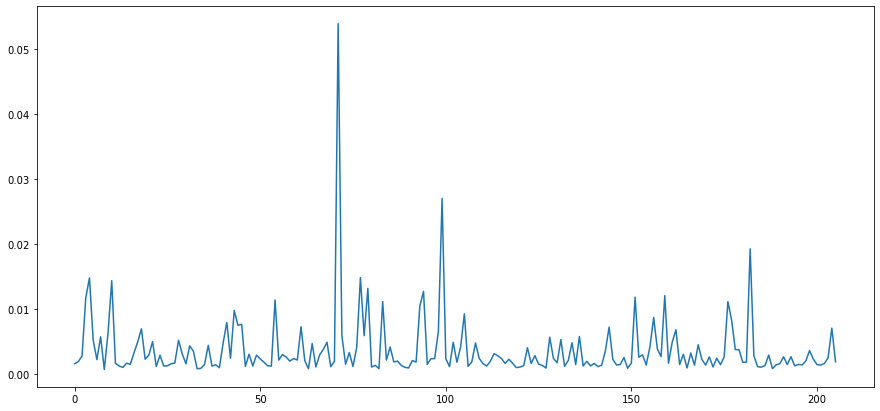

In [114]:
plt.plot(final_preds[0])

In [115]:
noice_weights

array([0.        , 0.        , 0.        , 0.87195912, 0.34000957,
       0.21308832, 0.        , 0.49556422, 0.68591618, 0.59005981,
       0.59195287, 0.67233153, 0.27887094, 0.        ])

In [116]:
sample_submission_columns = pd.read_csv("../input/lish-moa/sample_submission.csv").columns[1:]
sig_ids = pd.read_csv("../input/lish-moa/sample_submission.csv")["sig_id"].values

pred_df = pd.DataFrame(final_preds, columns= sample_submission_columns)
pred_df["sig_id"] = sig_ids
columns_arrangement = ["sig_id"]
columns_arrangement.extend(pred_df.columns[:-1])
pred_df = pred_df[columns_arrangement]
save_name = "submission.csv"
print("saved: ", save_name)
pred_df.to_csv(save_name, index = False)


saved:  submission.csv


In [117]:
pred_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001549,0.001887,0.002741,0.011707,0.014774,0.005184,0.002182,0.005693,0.000662,...,0.001366,0.001978,0.003576,0.002285,0.001420,0.001346,0.001585,0.002480,0.007038,0.001837
1,id_001897cda,0.001013,0.001464,0.002228,0.001674,0.002923,0.002566,0.003447,0.007831,0.003249,...,0.001288,0.001411,0.003982,0.001686,0.005438,0.001064,0.009198,0.001250,0.001048,0.002516
2,id_002429b5b,0.000268,0.000273,0.000381,0.000564,0.000871,0.000372,0.000398,0.000631,0.000182,...,0.000268,0.000343,0.000371,0.000582,0.000553,0.000196,0.000734,0.000307,0.000160,0.000290
3,id_00276f245,0.001550,0.001440,0.001902,0.006790,0.015565,0.004555,0.002779,0.005023,0.000748,...,0.000984,0.001623,0.002806,0.028274,0.003311,0.000963,0.001663,0.001696,0.000858,0.002102
4,id_0027f1083,0.002762,0.002293,0.002915,0.010502,0.014449,0.005321,0.003270,0.002455,0.000918,...,0.001357,0.001100,0.003614,0.002736,0.001589,0.001237,0.001983,0.002294,0.000849,0.002273
